Ref: https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055

PyTorch Image Models (timm) is a library for state-of-the-art image classification, containing a collection of image models, optimizers, schedulers, augmentations and much more.

Due to the rate that new architectures and training techniques are introduced into this rapidly moving field, whether you are a beginner or an expert , it can be difficult to keep up with the latest practices and make it challenging to know where to start when approaching new vision tasks with the intention of reproducing similar results to those presented in academic benchmarks.

Whether training from scratch or finetuning existing models to new tasks, and looking to leverage pre-existing components to speed up your workflow, timm is favourite libraries for computer vision in PyTorch. However, whilst timm contains reference training(https://github.com/rwightman/pytorch-image-models/blob/master/train.py) and validation scripts(https://github.com/rwightman/pytorch-image-models/blob/master/validate.py )for reproducing ImageNet training results and has documentation covering the core components in the official documentation(https://rwightman.github.io/pytorch-image-models/) and the timmdocs project(https://fastai.github.io/timmdocs/), due to the sheer number of features that the library provides it can be difficult to know where to get started when applying these in custom use-cases.

The purpose of this guide is to explore timm from a practitioner’s point of view, focusing on how to use some of the features and components included in timm in custom training scripts. The focus is not to explore how or why these concepts work, or how they are implemented in timm; for this, links to the original papers will be provided where appropriate, and I would recommend timmdocs https://fastai.github.io/timmdocs/ to learn more about timm’s internals. Additionally, this article is by no means exhaustive, the areas selected are based upon my personal experience using this library.

###**Table of Contents**

- Models
    - Customizing models
    - Feature Extraction
    - Exporting to different formats
- Data Augmentation
    - RandAugment
    - CutMix and MixUp
- Datasets
    - Loading datasets from TorchVision
    - Loading datasets from TensorFlow Datasets
    - Loading datasets from local folders
    - The ImageDataset class
- Optimizers
    - Usage Example
    - Lookahead
- Schedulers
    - Usage Example
    - Adjusting learning rate schedules
- Exponential Moving Average model
- Putting it all together!

In [1]:
import torch
try:
    import timm
except:
    !pip install timm
    import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.7 MB/s eta 0:00:00


####**Models**

One of the most popular features of timm is its large, and ever-growing collection of model architectures. Many of these models contain pretrained weights — either trained natively in PyTorch, or ported from other libraries such as Jax and TensorFlow — which can be easily downloaded and used.

We can list, and query, the collection available models as demonstrated below:

In [2]:
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [3]:
len(timm.list_models())

1017

In [4]:
len(timm.list_models("*"))

1017

We can also use the ```pretrained argument``` to filter this selection to the models with pretrained weights:

In [5]:
len(timm.list_models(pretrained=True))

1298

This is still an impressive number! If you are experiencing a little option paralysis at this point, don’t despair! A helpful resource which can be used to explore some of the models available, and understand their performance, is this summary page https://paperswithcode.com/lib/timm by Papers with code, which contains benchmarks and links to the original papers for many of the models included in timm.

For simplicity, let’s stick with the familiar, tried and tested, ResNet model family here. We can list the different ResNet variants available by providing a wildcard string, which will be used as a filter based on the model names:

In [6]:
timm.list_models("resnet50*", pretrained=True)

['resnet50.a1_in1k',
 'resnet50.a1h_in1k',
 'resnet50.a2_in1k',
 'resnet50.a3_in1k',
 'resnet50.am_in1k',
 'resnet50.b1k_in1k',
 'resnet50.b2k_in1k',
 'resnet50.bt_in1k',
 'resnet50.c1_in1k',
 'resnet50.c2_in1k',
 'resnet50.d_in1k',
 'resnet50.fb_ssl_yfcc100m_ft_in1k',
 'resnet50.fb_swsl_ig1b_ft_in1k',
 'resnet50.gluon_in1k',
 'resnet50.ra_in1k',
 'resnet50.ram_in1k',
 'resnet50.tv2_in1k',
 'resnet50.tv_in1k',
 'resnet50_gn.a1h_in1k',
 'resnet50c.gluon_in1k',
 'resnet50d.a1_in1k',
 'resnet50d.a2_in1k',
 'resnet50d.a3_in1k',
 'resnet50d.gluon_in1k',
 'resnet50d.ra2_in1k',
 'resnet50s.gluon_in1k']

As we can see, there are still a lot of options! Now, let’s explore how we can create a model from this list.

####**General Usage**
The easiest way to create a model is by using ```create_model```; a factory function that can be used to create any model in the timm library.

Let’s demonstrate this by creating a Resnet-D model, as introduced in the ```Bag of Tricks for Image Classification For Convolutional Neural Networks``` paper; which is a modification on the ResNet architecture that utilises an average pooling tweak for down-sampling. This was largely an arbitrary choice, and the features that are demonstrated here should work on the majority of models included in timm.

In [7]:
model_resnet50d = timm.create_model(model_name="resnet50d.a1_in1k", pretrained=True)

model.safetensors:   0%|          | 0.00/103M [00:00<?, ?B/s]

In [8]:
model_resnet50d

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

As we can see, this is just a regular PyTorch model.

To help us understand more about how to use this model, we can access its ```config```, which contains information such as the ```statistics``` that should be used to normalise the input data, the ```number of output classes``` and the ```name of the classification portion``` of the network.

In [9]:
model_resnet50d.default_cfg

{'url': 'https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50d_a1_0-e20cff14.pth',
 'hf_hub_id': 'timm/resnet50d.a1_in1k',
 'architecture': 'resnet50d',
 'tag': 'a1_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1.0',
 'classifier': 'fc',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

**Pretrained Models for images with varying numbers of input channels**

One less well known, but incredibly useful, feature of timm models is that they are able to work on input images with varying numbers of channels, which pose a problem for most other libraries; an excellent explanation of how this works is described here https://fastai.github.io/timmdocs/models#So-how-is-timm-able-to-load-these-weights?. Intuitively, timm does this by summing the weights of the initial convolutional layer for channels fewer than 3, or intelligently replicating these weights to the desired number of channels otherwise.

We can specify the number of channels for our input images by passing the in_chans argument to create_model.

In [10]:
model_resnet50d_1channel = timm.create_model(
    model_name="resnet50d.a1_in1k",
    pretrained=True,
    in_chans=1)

#create a dummy single channel image
dummy_img = torch.rand((1, 1, 224, 224))

model_resnet50d_1channel(dummy_img).shape

torch.Size([1, 1000])

Using a random tensor to represent a single channel image in this case, we can see that the model has processed the image and returned the expected output shape.

It is important to note that, whilst this has enabled us to use a pretrained model, the input is significantly different to the images that the model was trained on. Because of this, we should not expect the same level of performance, and finetune the model on the new dataset before using it on the task!



####**Customizing Models**
In addition to creating models with stock architectures, ```create_model``` also supports a number of arguments enabling us to customise a model for our task.

The arguments that are supported can depend on the underlying model architecture, with some arguments such as:

- ```global_pool```: determine the type of global pooling to be used before the final classification layers

being model specific. In this case, it is dependent on whether the architecture employs a global pooling layer. Therefore, whilst we will be fine using this with a ResNet-like model, it wouldn’t make sense to use it with ViT, which doesn’t use average pooling.

Whilst some arguments are model specific, arguments such as:

- ```drop_rate```: set the dropout rate for training (Default: `0`)
- ```num_classes```: the number of output neurons corresponding to classes

can be used for almost all models.

Before we explore some of the ways that we can do this, lets examine the default architecture of our current model.

**Changing the number of classes**

Examining the model config that we saw earlier, we can see that the name of the classification head for our network is ```fc```. We can use this to access the corresponding module directly.

In [11]:
model_resnet50d.default_cfg

{'url': 'https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50d_a1_0-e20cff14.pth',
 'hf_hub_id': 'timm/resnet50d.a1_in1k',
 'architecture': 'resnet50d',
 'tag': 'a1_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1.0',
 'classifier': 'fc',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

In [12]:
model_resnet50d.layer1 #accessing the layer1

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_block): Identity()
    (act2): ReLU(inplace=True)
    (aa): Identity()
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act3): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Identity()
      (1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1),

In [13]:
model_resnet50d

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

In [14]:
model_resnet50d.fc #accessing the classification layer

Linear(in_features=2048, out_features=1000, bias=True)

However, this name is likely to change depending on the model architecture used. To provide a consistent interface for different models, timm models have the ```get_classifier()``` method, which we can use to retrieve the classification head without having to lookup the module name.

In [15]:
model_resnet50d.get_classifier()

Linear(in_features=2048, out_features=1000, bias=True)

As expected, this returns the same linear layer as before.

As this model was pretrained on ImageNet, we can see that the final layer outputs 1000 classes. We can change this with the ```num_classes``` argument to the ```create_model()```



In [16]:
timm.create_model(
    model_name="resnet50d.a1_in1k",
    pretrained=True,
    num_classes=10).get_classifier()

Linear(in_features=2048, out_features=10, bias=True)

Inspecting the classifier, we can see that timm has replaced the final layer with a new, untrained, linear layer with the desired number of classes; ready to ```finetune``` on our dataset!

If we would like to avoid creating the last layer completely, we can set the number of classes equal to 0, which will create a model with the identity function as the final layer; this can be useful for inspecting the output of the penultimate layer.(last but one layer)



In [17]:
timm.create_model(
    model_name="resnet50d.a1_in1k",
    pretrained=True,
    num_classes=0).get_classifier()

Identity()

####**Global pooling options**

From our model’s config, we can also see that the ```pool_size``` is set, informing us that a ```global pooling layer``` is used before the classifier. We can inspect this as follows:

In [18]:
model_resnet50d.default_cfg

{'url': 'https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50d_a1_0-e20cff14.pth',
 'hf_hub_id': 'timm/resnet50d.a1_in1k',
 'architecture': 'resnet50d',
 'tag': 'a1_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1.0',
 'classifier': 'fc',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

In [19]:
model_resnet50d.global_pool

SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))

Here, we can see that this returns an instance of ```SelectAdaptivePool2d```, which is a custom layer provided by timm, which supports different pooling and flattening configurations. At the time of writing, the supported pooling options are:

- ```avg``` : Average pooling
- ```max``` : Max pooling
- ```avgmax```: the sum of average and max pooling, re-scaled by 0.5
- ```catavgmax```: a concatenation of the outputs of average and max pooling along feature dimension. Note that this will double the feature dimension.
- ```‘’ ```: No pooling is used, the pooling layer is replaced by an Identity operation

We can visualise the output shapes of the different pooling options as demonstrated below:

In [20]:
pool_types = ["avg", "max", "avgmax", "catavgmax", ""]

for pool in pool_types:
    mymodel = timm.create_model(
        model_name="resnet50d.a1_in1k", pretrained=True, num_classes=0, global_pool=pool
        )
    mymodel.eval()
    rand_img = torch.rand((1, 3, 224, 224))
    feature_output = mymodel(rand_img) #we get feature output cuz we removed classification layer using num_classes=0
    print(feature_output.shape)

torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 4096])
torch.Size([1, 2048, 7, 7])


####**Modifying an existing model**

We can also modify the classifier and pooling layers of an existing model, using the ```reset_classifier``` method instead of changing ```num_classes``` and ```global_pool``` attribute to ```create_model```

In [21]:
mymodel = timm.create_model(
        model_name="resnet50d.a1_in1k", pretrained=True
        )
print(f"Original Global Pool: {mymodel.global_pool}")
print(f"Original Classifier: {mymodel.get_classifier()}")

mymodel.reset_classifier(num_classes=10, global_pool="max")

print(f"\nModified Global Pool: {mymodel.global_pool}")
print(f"Modified Classifier: {mymodel.get_classifier()}")

Original Global Pool: SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
Original Classifier: Linear(in_features=2048, out_features=1000, bias=True)

Modified Global Pool: SelectAdaptivePool2d(pool_type=max, flatten=Flatten(start_dim=1, end_dim=-1))
Modified Classifier: Linear(in_features=2048, out_features=10, bias=True)


####**Creating a new classification head**

Whilst it has been demonstrated that using a ```single linear layer as our classifier``` is sufficient to achieve good results, when ```finetuning models on downstream task```s, I’ve often found that using a slightly ```larger head``` can lead to increased performance. Let’s explore how we can modify our ResNet model further.

First, let’s create our ResNet model as before, specifying that we would like ```10 classes```. As we are using a ```larger head```, let’s use ```catavgmax``` for our pooling, so that we provide more information as input to our classifier.

In [22]:
model_resnet50d.num_classes, model_resnet50d.global_pool

(1000,
 SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1)))

In [23]:
mymodel = timm.create_model(
        model_name="resnet50d.a1_in1k", pretrained=True,
        num_classes=10, global_pool="catavgmax"
    )

From the existing classifier, we can get the number of input features:

In [24]:
mymodel.get_classifier()

Linear(in_features=4096, out_features=10, bias=True)

In [25]:
num_in_features = mymodel.get_classifier().in_features; num_in_features

4096

Now, we can replace the final layer  with our modified classification head by accessing the classifier directly i.e using ```model.fc```. Here, the classification head has been chosen somewhat arbitrarily.

In [26]:
num_in_features

4096

In [27]:
from torch import nn
mymodel.fc = nn.Sequential(
    nn.BatchNorm1d(num_features=num_in_features),
    nn.Linear(in_features=num_in_features, out_features=512, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=512, eps=0.00001, momentum=0.1),
    nn.Dropout(p=0.4),
    nn.Linear(in_features=512, out_features=10, bias=False)
)

Testing the model with a dummy input, we get an output of the expected shape. Now, our modified model is ready to train!

In [28]:
dummy_img = torch.rand((1, 3, 224, 224))
mymodel.eval()
mymodel(dummy_img).shape

torch.Size([1, 10])

####**Feature Extraction**
timm models also have consistent mechanisms for obtaining various types of intermediate features, which can be useful in order to use an architecture as a feature extractor for a downstream task; such as creating feature pyramids in object detection.

Let’s visualise how this works by using an image from the Oxford pets dataset.

This ImageDataset in timm is very similar to torchvision.datasets.ImageFolder with some nice added features.

We can load the data when we have classification dataset format data files(remember pizza, sushi, steak dataset?)

In [29]:

from torchvision.datasets import ImageFolder, OxfordIIITPet
from timm.data.dataset import ImageDataset

pets_dataset = OxfordIIITPet(root="./", split="trainval", download=True)

100%|██████████| 791918971/791918971 [00:24<00:00, 31880279.22it/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 16278237.78it/s]


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


In [30]:
pets_dataset[0]

(<PIL.Image.Image image mode=RGB size=394x500>, 0)

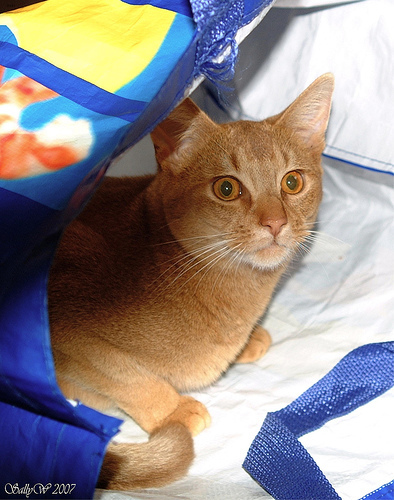

In [31]:
from PIL import Image

petimg = pets_dataset[0][0]
petimg

This is a PIL Image. We can convert this into a tensor, and transpose the channels into the format that PyTorch expects: (C, H, W)

In [32]:
petimg.size #W, H

(394, 500)

In [33]:
import numpy as  np
torch.as_tensor(np.array(petimg, dtype=np.float32)).shape

torch.Size([500, 394, 3])

In [34]:
import numpy as  np

mypetimg = torch.as_tensor(np.array(petimg, dtype=np.float32)).transpose(dim0=2, dim1=0)[None]
mypetimg.shape

torch.Size([1, 3, 394, 500])

Once again, let’s create our ResNet-D model:

In [35]:
mymodel = timm.create_model(
        model_name="resnet50d.a1_in1k", pretrained=True
    )

In [36]:
mymodel.default_cfg

{'url': 'https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50d_a1_0-e20cff14.pth',
 'hf_hub_id': 'timm/resnet50d.a1_in1k',
 'architecture': 'resnet50d',
 'tag': 'a1_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1.0',
 'classifier': 'fc',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

If we are only interested in the final feature map — that is the output of the final convolutional layer prior to pooling in this case — we can use the ```forward_features() ``` method to bypass the global pooling and classification layers.

In [37]:
feature_output = mymodel.forward_features(mypetimg)
feature_output.shape

torch.Size([1, 2048, 13, 16])

In [38]:
feature_output[0].shape #accesing the feature output of first example in a batch.Here we have only one example in a batch

torch.Size([2048, 13, 16])

In [39]:
feature_output[0].transpose(0, 2).shape #changing it to matplotlib format H, W, C

torch.Size([16, 13, 2048])

In [40]:
feature_output[0].transpose(0, 2).sum(-1).shape #adding along the channels dimension

torch.Size([16, 13])

We can visualise this below:

In [41]:
import matplotlib.pyplot as plt

def visualize_feature_output(feature_output):
    plt.imshow(feature_output[0].transpose(0, 2).sum(-1).detach().numpy())
    plt.show()

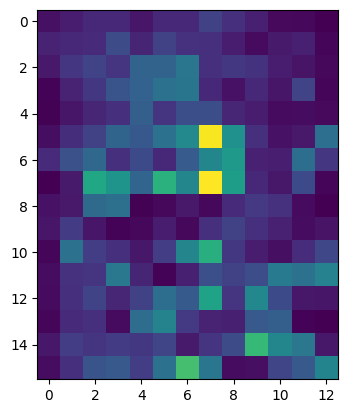

In [42]:
visualize_feature_output(feature_output)

####**Multiple feature outputs**

Whilst the forward features method can be convenient for retrieving the final feature map, timm also provides functionality which enables us to use models as feature backbones that output feature maps for selected levels.

We can specify that we would like to use a model as a feature backbone by using the argument ```features_only=True``` when creating a model. By default, 5 strides will be output from most models (not all have that many), with the first starting at 2 (but some start at 1 or 4).

The indices of the feature levels, and number of strides can be modified using the `out_indices` and `output_stride` arguments, as demonstrated in the docs. https://rwightman.github.io/pytorch-image-models/feature_extraction/#multi-scale-feature-maps-feature-pyramid

Let’s see how this works with our ResNet-D model.

In [43]:
mymodel_as_backbone = timm.create_model(model_name="resnet50d.a1_in1k",
                                        pretrained=True,
                                        features_only=True)

As demonstrated below, we can get more information about the features that are returned, such as the specific `module names`, the `reduction in features` and the `number of channels`:

In [44]:
mymodel_as_backbone.feature_info.module_name()

['act1', 'layer1', 'layer2', 'layer3', 'layer4']

In [45]:
mymodel_as_backbone.feature_info.reduction()

[2, 4, 8, 16, 32]

In [46]:
mymodel_as_backbone.feature_info.channels()

[64, 256, 512, 1024, 2048]

Now, lets pass an image through our feature extractor and explore the output.

In [47]:
out = mymodel_as_backbone(mypetimg)
#out

In [48]:
len(out)

5

As expected, 5 feature maps have been returned. Inspecting the shape, we can see that the number of channels is consistent with what we expect:



In [49]:
for o in out:
    print(o.shape)

torch.Size([1, 64, 197, 250])
torch.Size([1, 256, 99, 125])
torch.Size([1, 512, 50, 63])
torch.Size([1, 1024, 25, 32])
torch.Size([1, 2048, 13, 16])


Visualising each feature map, we can see that the image is gradually down-sampled, as we would expect.

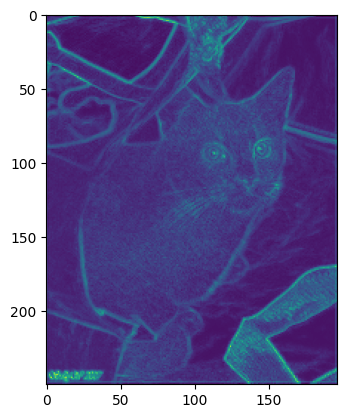

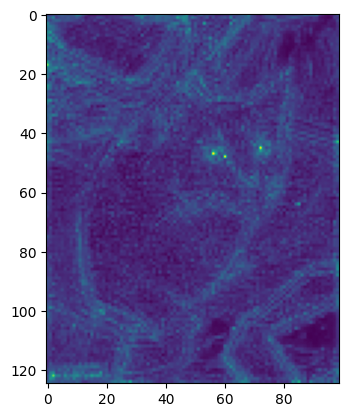

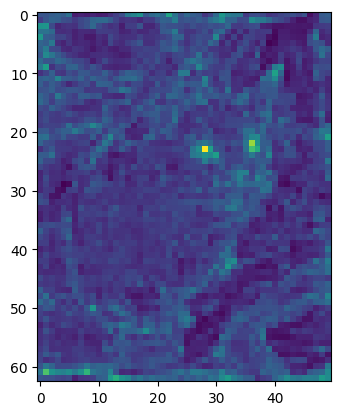

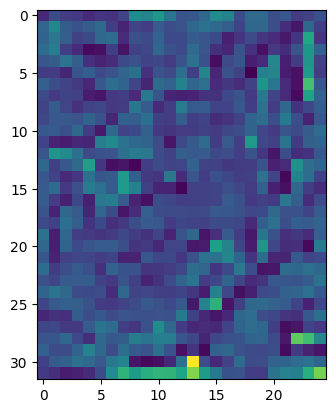

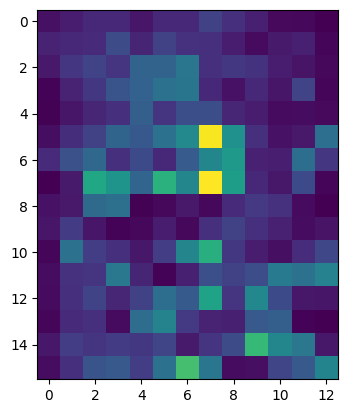

In [50]:
for o in out:
    plt.imshow(o[0].transpose(0, 2).sum(-1).detach().numpy())
    plt.show()

In [51]:
def visualize_feature_maps(feature_maps):
    for o in feature_maps:
        plt.imshow(o[0].transpose(0, 2).sum(-1).detach().numpy())
        plt.show()

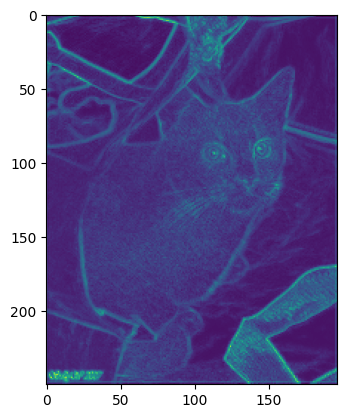

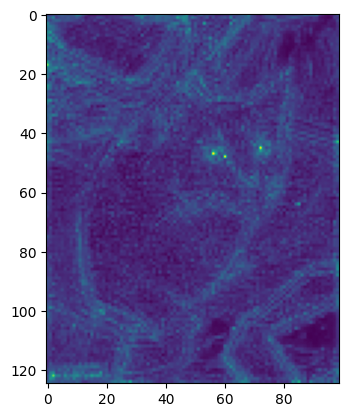

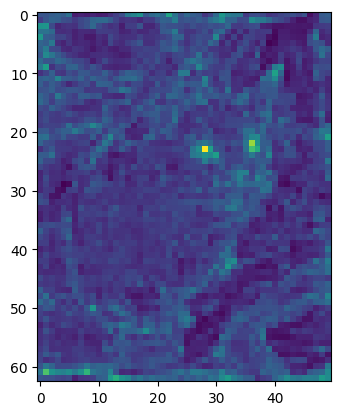

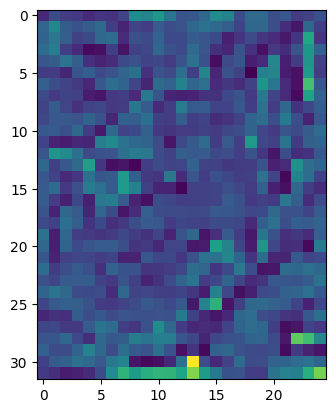

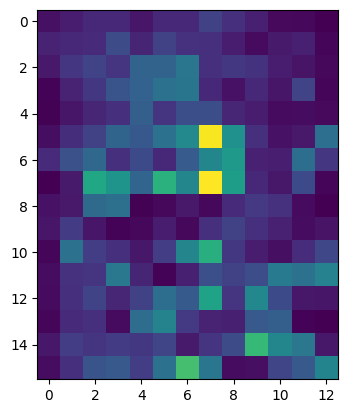

In [52]:
visualize_feature_maps(out)

####**Using Torch FX**

TorchVision recently released a new utility called FX, which makes it easier to access intermediate transformations of an input during the forward pass of a PyTorch Module. This is done by symbolically tracing the forward method to produce a graph where each node represents a single operation. As nodes are given human-readable names, it is easy specify exactly which nodes we want to access. FX is described in more detail in the docs https://pytorch.org/docs/stable/fx.html#module-torch.fx and in this blog post. https://pytorch.org/blog/FX-feature-extraction-torchvision/

Note: At the time of writing, dynamic control flow can’t yet be represented in terms of a static graph when using FX.

PyTorch is shipped with FX toolkit that includes "three main components: a symbolic tracer(traceable), an intermediate representation(scriptable), and Python code generation.".

A symbolic tracer builds a graph of the execution of some module (e.g., a function), i.e., the semantics of it. Such graph can be helpful to inspect the internals of your modules.

As almost all models in timm are symbolically traceable, we can use FX to manipulate these. Let’s explore how we can use FX to extract features from timm models.

First, let’s import some helper methods from TorchVision:

In [53]:
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

Now, we recreate our ResNet-D model, with a classification head, and use the exportable argument to ensure that the model is traceable.

In [54]:
model = timm.create_model(model_name="resnet50d.a1_in1k",
                          pretrained=True,
                          exportable=True)

Now, we can use the `get_graph_nodes` method to return the node names in order of execution. As the model is traced twice, in train and eval modes, both sets of node names are returned.

In [55]:
train_nodes, eval_nodes = get_graph_node_names(model)
train_nodes

['x',
 'conv1.0',
 'conv1.1',
 'conv1.2',
 'conv1.3',
 'conv1.4',
 'conv1.5',
 'conv1.6',
 'bn1',
 'act1',
 'maxpool',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.act1',
 'layer1.0.conv2',
 'layer1.0.bn2',
 'layer1.0.drop_block',
 'layer1.0.act2',
 'layer1.0.aa',
 'layer1.0.conv3',
 'layer1.0.bn3',
 'layer1.0.downsample.0',
 'layer1.0.downsample.1',
 'layer1.0.downsample.2',
 'layer1.0.add',
 'layer1.0.act3',
 'layer1.1.conv1',
 'layer1.1.bn1',
 'layer1.1.act1',
 'layer1.1.conv2',
 'layer1.1.bn2',
 'layer1.1.drop_block',
 'layer1.1.act2',
 'layer1.1.aa',
 'layer1.1.conv3',
 'layer1.1.bn3',
 'layer1.1.add',
 'layer1.1.act3',
 'layer1.2.conv1',
 'layer1.2.bn1',
 'layer1.2.act1',
 'layer1.2.conv2',
 'layer1.2.bn2',
 'layer1.2.drop_block',
 'layer1.2.act2',
 'layer1.2.aa',
 'layer1.2.conv3',
 'layer1.2.bn3',
 'layer1.2.add',
 'layer1.2.act3',
 'layer2.0.conv1',
 'layer2.0.bn1',
 'layer2.0.act1',
 'layer2.0.conv2',
 'layer2.0.bn2',
 'layer2.0.drop_block',
 'layer2.0.act2',
 'layer2.0.aa'

Using FX, can use easily access the output from any node. Let’s select the second activation in layer1.

In [56]:
features = {"layer1.0.act2": "out"}

Using `create_feature_extractor`, we can ‘cut’ the model at that point, as we can see below

In [57]:
feature_extractor = create_feature_extractor(model, return_nodes=features)

In [58]:
feature_extractor

ResNet(
  (conv1): Module(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64,

Now, passing an image through our feature extractor this will return a dict of Tensors. We can then visualise this as before:

In [59]:
out = feature_extractor(mypetimg) #returns dictionary with key as "out" and value is the specified node output tensor

In [60]:
#out

In [61]:
out.keys(), out["out"].shape

(dict_keys(['out']), torch.Size([1, 64, 99, 125]))

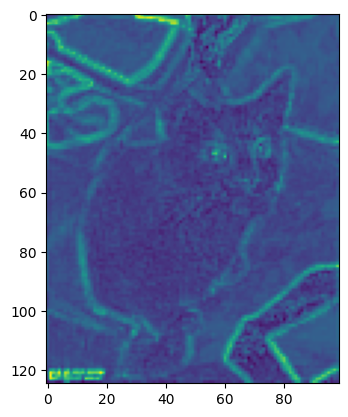

In [62]:
plt.imshow(out["out"][0].transpose(0, 2).sum(-1).detach().numpy())

####**Exporting to different formats**
After training, it is often recommended to export your models to an optimized format for inference; PyTorch has multiple options for doing this. As almost all timm models are scriptable and traceable, we can make use of these formats.

Let’s examine some of the options available.

- Exporting to `TorchScript`
- Exporting to `ONNX`

####**Exporting to TorchScript**

TorchScript is a way to create serializable and optimizable models from PyTorch code; any TorchScript program can be saved from a Python process and loaded in a process where there is no Python dependency.

We can convert a model to TorchScript in two different ways:

- `Tracing`: runs the code, records the operations that happen and constructs a ScriptModule containing those operations. Control flow, or dynamic behaviour such as if/else statements are erased.`timm.create_model(..., exportable=True)`
- `Scripting`: uses a script compiler to perform a direct analysis of your Python source code to transform it into TorchScript. This preserves dynamic control flow and is valid for inputs of different sizes. `timm.create_model(..., scriptable=True)`

More about TorchScript can be seen in the docs https://pytorch.org/docs/stable/jit.html and in this tutorial.https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html

As most timm models are scriptable, let’s use scripting to export our ResNet-D model. We can set layer config so that model is jit scriptable using the scriptable argument when creating our model.

In [63]:
model = timm.create_model(
    model_name="resnet50d.a1_in1k",
    pretrained=True,
    scriptable=True
)
model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

It is important to call `model.eval()` before exporting the model, to put the model into inference mode, as operators such as dropout and batchnorm behave differently depending on the mode.

We can now verify that we are able to script and use our model.

In [64]:
scripted_model = torch.jit.script(model)

In [65]:
scripted_model

RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=Conv2d)
    (4): RecursiveScriptModule(original_name=BatchNorm2d)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=Conv2d)
  )
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (act1): RecursiveScriptModule(original_name=ReLU)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Bottleneck
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (act1): RecursiveScriptModule(original_name=ReLU)
      (conv2): RecursiveScriptModule

In [66]:
scripted_model(torch.rand((8, 3, 224, 224))).shape

torch.Size([8, 1000])

####**Exporting to ONNX**

Open Neural Network eXchange (ONNX) is an open standard format for representing machine learning models.

We can use the `torch.onnx` module to export timm models to ONNX; enabling them to be consumed by any of the many runtimes that support ONNX. If `torch.onnx.export()` is called with a Module that is not already a ScriptModule, it first does the equivalent of `torch.jit.trace()`; which executes the model once with the given args and records all operations that happen during that execution. This means that if the model is dynamic, e.g., changes behaviour depending on input data, the exported model will not capture this dynamic behaviour. Similarly, a trace is likely to be valid only for a specific input size.

More details on ONNX can be found in the docs.https://pytorch.org/docs/master/onnx.html

To enable exporting a timm model in ONNX format, we can use the `exportable` argument when creating the model, to ensure that the model is traceable.

In [67]:
model = timm.create_model(
    model_name="resnet50d.a1_in1k",
    pretrained=True,
    exportable=True)
model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

We can now use torch.onnx.export to trace and export our model:

In [68]:
try:
    import onnx
except:
    !pip install onnx
x = torch.randn((2, 3, 244, 244), requires_grad=True)
torch_out = model(x)

#export the model
torch.onnx.export(model=model, #model being run
                  args=x,      #model input or a tuple of multiple inputs
                  f="resnet50d.onnx", #where to save the mode (can be a file or file-like obj)
                  export_params=True, #store the trained parameter wieghts inside the model file
                  input_names=["input"], #model input names
                  output_names=["output"], #model output names
                  opset_version=10, #the onnx version to export the model to
                  do_constant_folding=True, #whether to execute constant folding for optimization
                  dynamic_axes={"input": {0: "batch_size"},   #variable length axes
                                "output": {0: "batch_size"}}
                  )

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 21.2 MB/s eta 0:00:00


We can now verify that our model is valid using the `check_model` function

In [69]:
import onnx
onnx_model = onnx.load("resnet50d.onnx")
onnx.checker.check_model(onnx_model)

In [70]:
onnx_model

As we specified that our model should be traceable, we could also have performed the tracing manually as demonstrated below.

In [ ]:
#Manual tracing
traced_model = torch.jit.trace(model, torch.rand(8, 3, 224, 224))

In [ ]:
type(traced_model)

In [ ]:
traced_model(torch.rand(8, 3, 224, 224)).shape

###**Data Augmentation**
timm includes lots of data augmentation transforms, which can be chained together to make augmentation pipelines; similarly to TorchVision, these pipelines expect a PIL image as an input.

The easiest way to get started is by using the `create_transform` factory function, let’s explore how we can use this below.



In [ ]:
from timm.data.transforms_factory import create_transform

In [ ]:
create_transform(input_size=224)

In [ ]:
create_transform(input_size=224, is_training=True)

Here, we can see that this has created some basic augmentation pipeline including resizing, normalization and converting an image to a tensor. As we would expect, we can see that additional transformations, such as horizontal flipping and colour jitter, are included when we set `is_training=True`. The magnitude of these augmentations can be controlled with arguments such as `hflip`, `vflip` and `color_jitter`.

We can also see that the method used to resize the image also varies depending on whether we are training. Whilst a standard Resize and CenterCrop are used during validation, during training, `RandomResizedCropAndInterpolation` is used, let’s see what it does below. As the implementation of this transform in timm enables us to set different methods of image interpolation; here we are selecting that the interpolation is selected at random.

In [ ]:
from timm.data.transforms import RandomResizedCropAndInterpolation

transform = RandomResizedCropAndInterpolation(size=350, interpolation="random")

In [ ]:
petimg

In [ ]:
#Visualize the RandomResizedCropAndInterpolation
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize=(10, 5))

transformed_imgs = [transform(petimg) for _ in range(4)]
for i, img in enumerate(transformed_imgs):
    ax[0, i].imshow(img)

for i, img in enumerate([transform(petimg) for _ in range(4)]):
    ax[1, i].imshow(img)

fig.tight_layout()
plt.show()



Running the transformation several times, we can observe that different crops have been taken of the image. Whilst this is beneficial during training, this may make the task harder during evaluation.

Depending on the type of image, this type of transform may result in the subject of the picture being cropped out of the image; we can see an example of this if we look at the second image in the second row! Whilst this shouldn’t be a huge problem if it occurs infrequently, we can avoid this by adjusting the scale parameter:



In [ ]:
transform = RandomResizedCropAndInterpolation(size=224, scale=(0.8, 1))

In [ ]:
transform(petimg)

####**RandAugment**
When starting a new task, it can be difficult to know which augmentations to use, and in which order; with the amount of augmentations now available, the number of combinations is huge!

Often, a good place to start is by using an augmentation pipeline which has demonstrated good performance on other tasks. One such policy is `RandAugment`, an automated data augmentation method that uniformly samples operations from a set of augmentations — such as `equalization, rotation, solarization, color jittering, posterizing, changing contrast, changing brightness, changing sharpness, shearing, and translations` — and applies a number of these sequentially; for more info, see the original paper.https://arxiv.org/abs/1909.13719

However, there are several key differences in the implementation provided in timm, which are best described by timm’s creator Ross Wightman in the appendix of the ResNets Strike Back paper, https://arxiv.org/pdf/2110.00476v1.pdf which I paraphrase below:

```
The original RandAugment specification has two hyper-parameters, M and N; where M is the distortion magnitude and N is the number of distortions uniformly sampled and applied per-image. The goal of RandAugment was that both M and N be human interpretable.
```

```
However, that ended up not being the case for M [in the original implementation]. The scales of several augmentations were backwards or not monotonically increasing over the range such that increasing M does not increase the strength of all augmentations.
```

In the original implementation, whilst some augmentations go up in strength as M increases, others decrease or are removed entirely, such that each M essentially represents its own policy.

The implementation in timm attempts to improve this situation by adding an `increasing` mode [enabled by default] where all augmentation strengths increase with magnitude.

This makes increasing M more intuitive, as all augmentations should now decrease/increase in strength with corresponding decrease/increase in M.

[Additionally,] timm adds a `MSTD` parameter, which adds gaussian noise with the specified standard deviation to the M value per distortion application. If MSTD is set to ‘-inf’, M is uniformly sampled from 0-M for each distortion.

Care was taken in timm’s RandAugment to reduce impact on image mean, the normalization parameters can be passed as a parameter such that all augmentations that may introduce border pixels can use the specified mean instead of defaulting to 0 or a hard-coded tuple as in other implementations.

[Lastly,] Cutout is excluded by default to favour separate use of timm’s Random Erasing implementation* which has less
impact on mean and standard deviation of the augmented images.

*The implementation of Random Erasing in timm is explored in detail here. https://fastai.github.io/timmdocs/RandomErase

Now that we understand what RandAugment is, let’s see how we can use it in an augmentation pipeline!

In timm, we define the parameters of our RandAugment policy by using a `config string`; which consists of multiple sections separated by dashes (-)

The first section defines the specific variant of rand augment (currently only rand is supported). The remaining sections, which can be placed in any order, are:

- m (integer): the magnitude of rand augment
- n (integer): the number of transform ops selected per image, this is optional with default set at 2
- mstd (float): the standard deviation of the magnitude noise applied
- mmax (integer): sets the upper bound for magnitude to something other than the default of 10
- w (integer): the probability weight index (index of a set of weights to influence choice of operation)
- inc (bool — {0, 1}): use augmentations that increase in severity with magnitude, this is optional with the default of 0

**For example:**

`rand-m9-n3-mstd0.5`: results in RandAugment with magnitude 9, 3 augmentations per image, mstd 0.5
`rand-mstd1-w0`: results in mstd 1.0, weights 0, default magnitude m of 10, and 2 augmentations per image

Passing a config string to `create_transform`, we can see that this is handled by the `RandAugment` object, and we can see the names of all available ops:

In [ ]:
from timm.data.transforms_factory import create_transform

create_transform(input_size=224, is_training=True, auto_augment="rand-m9-mstd0.5")

We can also create this object for use in a custom pipeline by using the `rand_augment_transform` function, as demonstrated below:

In [ ]:
from timm.data.auto_augment import rand_augment_transform

In [ ]:
transform = rand_augment_transform(config_str="rand-m9-mstd0.5",
                                   hparams={"img_mean":(124, 116, 104)})

In [ ]:
transform

Let’s apply this policy to an image to visualise some of the transformations.

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize=(10, 5))

transformed_imgs = [transform(petimg) for _ in range(4)]
for i, img in enumerate(transformed_imgs):
    ax[0, i].imshow(img)

for i, img in enumerate([transform(petimg) for _ in range(4)]):
    ax[1, i].imshow(img)

fig.tight_layout()
plt.show()

From this, we can see that using RandAugment has given us lots of variations of our image!

####**CutMix and Mixup**
timm provides a flexible implementation of the CutMix and Mixup augmentations, using the `Mixup class`; which handles both augmentations and provides the option of switching between them.

Using `Mixup`, we can select from variety of different mixing strategies:

- `batch`: CutMix vs Mixup selection, lambda, and CutMix region sampling are performed per batch
- `pair`: mixing, lambda, and region sampling are performed on sampled pairs within a batch
- `elem`: mixing, lambda, and region sampling are performed per image within batch
- `half`: the same as elementwise but one of each mixing pair is discarded so that each sample is seen once per epoch

Let’s visualise how this works. To do this, we will need to create a DataLoader, iterate through it and apply the augmentations to the batch. Once again, we shall use images from the Pets dataset.

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import OxfordIIITPet

def create_dataloaderiterator():
    pets_dataset = OxfordIIITPet(root="./", transform=create_transform(224))
    dl = iter(DataLoader(pets_dataset, batch_size=2))
    return dl

In [ ]:
dataloader = create_dataloaderiterator()

In [ ]:
inputimgs, labels = next(dataloader)

In [ ]:
inputimgs.shape, labels.shape

Using helper functions from TorchVision and timmdocs https://fastai.github.io/timmdocs/mixup_cutmix, we can visualise the images in our batch with no augmentation applied:

In [ ]:
from torchvision.utils import make_grid
out = make_grid(inputimgs)
out.shape

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

imshow(out.cpu(), title=[x.item() for x in labels])


Now, let’s create our MixUp transform! `Mixup` supports the following arguments:

- `mixup_alpha` (float): mixup alpha value, mixup is active if > 0., (default: 1)
- `cutmix_alpha` (float): cutmix alpha value, cutmix is active if > 0. (default: 0)
- `cutmix_minmax` (List[float]): cutmix min/max image ratio, cutmix is active and uses this vs alpha if not None.
- `prob` (float): the probability of applying mixup or cutmix per batch or element (default: 1)
- `switch_prob` (float): the probability of switching to cutmix instead of mixup when both are active (default: 0.5)
- `mode` (str): how to apply mixup/cutmix params (default: batch)
- `label_smoothing` (float): the amount of label smoothing to apply to the mixed target tensor (default: 0.1)
- `num_classes` (int): the number of classes for the target variable

Let’s define a set of arguments so that we apply either mixup or cutmix to a batch of images, and alternate with the probability of 1, and use these to create our `Mixup` transformation:

As mixup and cutmix take place on a batch of images, we can place the batch on the GPU before we apply the augmentation to speed things up! Here, we can see that mixup has been applied to this batch of images.



In [ ]:
from timm.data.mixup import Mixup

mixup_args = {
    "mixup_alpha": 1.,
    "cutmix_alpha": 1.,
    "prob": 1,
    "switch_prob": 0.5,
    "mode": "batch",
    "label_smoothing": 0.1,
    "num_classes": 2
}

mixup_fn = Mixup(**mixup_args)

In [ ]:
import torchvision

inputimgs, labels = inputimgs.to(torch.device("cuda")), labels.to(torch.device("cuda"))

mixed_inputimgs, mixed_labels = mixup_fn(inputimgs, labels)

out = torchvision.utils.make_grid(mixed_inputimgs)

imshow(out.cpu(), title=mixed_labels)

Running the augmentation again, we can see that, this time, CutMix has been applied.

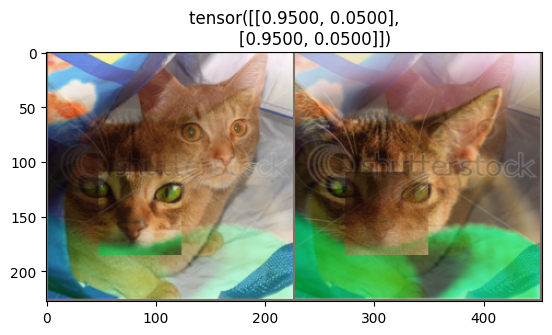

In [96]:
mixed_inputimgs, mixed_labels = mixup_fn(inputimgs, labels)

out = torchvision.utils.make_grid(mixed_inputimgs)

imshow(out.cpu(), title=mixed_labels)

In [97]:
mixed_inputimgs.shape, mixed_labels.shape

(torch.Size([2, 3, 224, 224]), torch.Size([2, 2]))

From the labels printed above each other, we can observe that we can also use Mixup for label smoothing! as regularizer

###**Datasets**
timm provides a number of useful utilities for working with different types of datasets. The easiest way to get started is using the `create_dataset` function, which will create an appropriate dataset for us.

`create_dataset` always expects two arguments:

- `name`: the name of the dataset that we want to load
- `root`: the root folder of the dataset on the local file system

but has additional keyword arguments that can be used to specify options such as whether we would like to load the training or validation set.

In [98]:
from timm.data import create_dataset

We can also use `create_dataset`, to load data from several different places:

- datasets available in TorchVision
- datasets available in TensorFlow datasets
- datasets stored in local folders

Let’s explore some of these options.

####**Loading datasets from TorchVision**
To load a dataset included with TorchVision, we simply specify the prefix `torch/` before the name of the dataset that we wish to load. If the data doesn’t exist on the file system, we can download this data by setting `download=True`. Additionally, here we are specifying that we would like to load the training dataset with the `split` argument.

In [99]:
cifar_ds = create_dataset(name="torch/cifar10", root="./cifar10", split="train", download=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 66184487.60it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


In [100]:
cifar_ds, type(cifar_ds)

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./cifar10
     Split: Train,
 torchvision.datasets.cifar.CIFAR10)

Inspecting the type, we can see that this is a TorchVision dataset. We can access this as usual with an index:

In [101]:
cifar_ds[0]

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

In [102]:
len(cifar_ds)

50000

In [103]:
cifar_ds.classes, cifar_ds.class_to_idx

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 {'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9})

####**Loading datasets from TensorFlow Datasets**
In addition to the datasets that are usually available when using PyTorch through TorchVision, timm also enables us to download and use datasets from TensorFlow datasets; wrapping the underlying tfds object for us.

When loading from TensorFlow datasets, it is recommended that we set a couple of additional arguments, which are not required for local or TorchVision datasets:

- `batch_size` : this is used to ensure that the batch size divides the total number of samples across all nodes during distributed training
- `is_training`: if set, the dataset will be shuffled. Note that this is different to setting split

Whilst this wrapper returns decompressed image examples from the TFDS dataset, any augmentations that we require, and batching, is still handled by PyTorch.

In this case, we prefix the name of the dataset with `tfds/`. A list of the available datasets for image classification can be found here https://pytorch.org/docs/stable/data.html#dataset-types. For this example, we shall arbitrarily select the beans dataset.



In [104]:
tf_ds = create_dataset(name="tfds/beans", root="./beans", split="train[:10%]",
                       download=True, batch_size=2, is_training=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling beans/beans/0.1.0.incomplete94R2MP/beans-train.tfrecord*...:   0%|          | 0/1034 [00:00<?, ? exa…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling beans/beans/0.1.0.incomplete94R2MP/beans-validation.tfrecord*...:   0%|          | 0/133 [00:00<?, ?…

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling beans/beans/0.1.0.incomplete94R2MP/beans-test.tfrecord*...:   0%|          | 0/128 [00:00<?, ? examp…

Dataset beans downloaded and prepared to ./beans/beans/0.1.0. Subsequent calls will reuse this data.


We can also see that, for the split argument, we have specified a `tfds split string`, as described here. https://www.tensorflow.org/datasets/splits

Inspecting our dataset, we can see that the underlying TensorFlow dataset has been wrapped in an `IterableImageDataset` object. As an iterable dataset, this does not support indexing — see the differences here https://pytorch.org/docs/stable/data.html#dataset-types — so in order to view an image from this dataset, we must first create an iterator.

In [105]:
tf_ds

In [106]:
tf_ds_iter = iter(tf_ds)

We can now use this iterator to examine our of images and labels sequentially, as we can see below.



In [107]:
img, label = next(tf_ds_iter)

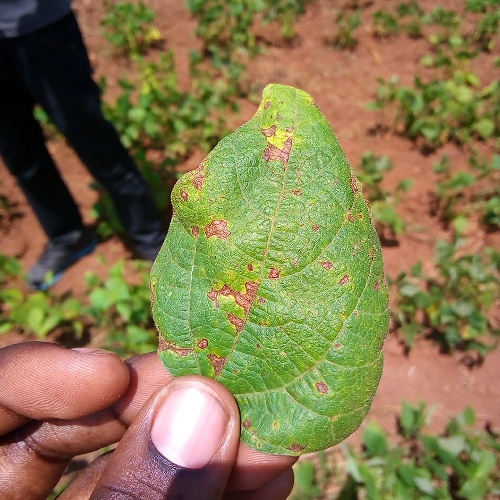

In [108]:
img

We can see that our image has been loaded correctly!

####**Loading data from local folders**
We can also load data from local folders, in these cases we simply use an empty string (`’’`) as the dataset name.

In addition to being able to load from ImageNet style folder hierarchies, `create_dataset` also lets us extract from one or more tar archives; we can use this to avoid having to untar the archive! As an example, we can try this out on the Imagenette dataset. https://github.com/fastai/imagenette

Additionally, so far we have been loading raw images, so let’s also use the `transform ` argument to apply some transformations; here, we can quickly create some suitable transforms using the `create_transform` function that we saw earlier!

In [109]:
# from fastai.vision.all import *

# PATH = untar_data(URLs.IMAGENETTE_160) #Get the dataset from fastai

In [110]:
#https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz - url that we get in fastapi github

# run only once
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
!gunzip imagenette2-320.tgz
!tar -xvf imagenette2-320.tar

Streaming output truncated to the last 5000 lines.
imagenette2-320/train/n03888257/n03888257_16077.JPEG
imagenette2-320/train/n03888257/n03888257_23339.JPEG
imagenette2-320/train/n03888257/n03888257_44204.JPEG
imagenette2-320/train/n03888257/n03888257_61633.JPEG
imagenette2-320/train/n03888257/n03888257_15067.JPEG
imagenette2-320/train/n03888257/n03888257_75365.JPEG
imagenette2-320/train/n03888257/n03888257_63966.JPEG
imagenette2-320/train/n03888257/n03888257_3927.JPEG
imagenette2-320/train/n03888257/n03888257_20684.JPEG
imagenette2-320/train/n03888257/ILSVRC2012_val_00047778.JPEG
imagenette2-320/train/n03888257/n03888257_14016.JPEG
imagenette2-320/train/n03888257/n03888257_37776.JPEG
imagenette2-320/train/n03888257/ILSVRC2012_val_00041706.JPEG
imagenette2-320/train/n03888257/n03888257_17513.JPEG
imagenette2-320/train/n03888257/n03888257_17143.JPEG
imagenette2-320/train/n03888257/n03888257_6738.JPEG
imagenette2-320/train/n03888257/n03888257_4355.JPEG
imagenette2-320/train/n03888257/ILS

In [111]:
from timm.data.transforms_factory import create_transform
from timm.data import create_dataset

imagenet_ds = create_dataset(name="",
                             root="./imagenette2-320.tar",
                             transform=create_transform(224))

In [112]:
imagenet_ds

In [113]:
img, label = imagenet_ds[0]

In [114]:
img.shape

torch.Size([3, 224, 224])

By inspecting the shame of the image, we can see that our transforms have been applied.

####**The ImageDataset class**
As we have seen, the `create_dataset` function offers a lot of options for handling different types of data. The reason that timm is able to offer such flexibility is by using the existing dataset classes provided in TorchVision where possible, as well as providing some additional implementations — `ImageDataset` and `IterableImageDataset` which can be used in a wide range of scenarios.

Essentially, `create_dataset` simplifies this process for us by selecting an appropriate class, but sometimes we may wish to work directly with the underlying components.

The implementation that I use the most often is `ImageDataset`, which is similar to `torchvision.datasets.ImageFolder`, but with some additional functionality. Let’s explore how we can use this to load our decompressed imagenette dataset.

In [115]:
from timm.data import ImageDataset

In [116]:
!ls imagenette*

imagenette2-320.tar

imagenette2-320:
noisy_imagenette.csv  train  val


In [117]:
imagenette_ds = ImageDataset(root="./imagenette2-320/train",
                             transform=create_transform(224))

In [118]:
imagenette_ds

In [119]:
img, label = imagenette_ds[0]
img.shape, label

(torch.Size([3, 224, 224]), 0)

In [120]:
len(imagenette_ds)

9469

The key to ```ImageDataset’s``` flexibility is that the way it indexes and loads samples is abstracted into a ```Parser``` (note: changed to ``reader``) object.

Several parser are included with timm, including parsers to read images from folders, tar files and TensorFlow datasets. The ```parser``` can be passed to the dataset as an argument, and we can access the parser directly.



In [121]:
#imagenette_ds.parser #looks like parser is not available in the upgrader version
imagenette_ds.reader #changed to reader

Here, we can see that the default parser is an instance of ParserImageFolder. Parsers also contain useful information such as the class lookup, which we can access as seen below.

In [122]:
#imagenette_ds.parser.class_to_idx
imagenette_ds.reader.class_to_idx

{'n01440764': 0,
 'n02102040': 1,
 'n02979186': 2,
 'n03000684': 3,
 'n03028079': 4,
 'n03394916': 5,
 'n03417042': 6,
 'n03425413': 7,
 'n03445777': 8,
 'n03888257': 9}

We can see that this reader has converted the raw labels into integers, which can be fed to our model.

In [123]:
imagenette_ds.reader[0] #accesing via index - gives img and label just like dataset as dataset wraps over reader

(<_io.BufferedReader name='./imagenette2-320/train/n01440764/ILSVRC2012_val_00000293.JPEG'>,
 0)

**Selecting a reader manually — tar example**

Therefore, in addition to selecting an appropriate class, `create_dataset` is also responsible for selecting the correct parser. Once again considering the compressed Imagenette dataset, we can achieve the same result by manually selecting the `ReaderImageInTar` reader and overriding ImageDataset’s default reader.

In [124]:
from timm.data.readers.reader_image_in_tar import ReaderImageInTar

data_path = "./" #path where tarfile exists
ds = ImageDataset(root=data_path, reader=ReaderImageInTar(data_path))

Inspecting the first sample, we can verify that this has loaded correctly.



In [125]:
ds[0]

(<PIL.Image.Image image mode=RGB size=426x320>, 0)

####**Creating a custom Reader**

Unfortunately, datasets aren’t always structured like ImageNet; that is, having the following structure:

```
root/class_1/xx1.jpg
root/class_1/xx2.jpg
root/class_2/xx1.jpg
root/class_2/xx2.jpg
```

For these datasets, `ImageDataset` won’t work out of the box. Whilst we can always implement a custom Dataset to handle this, this may be challenging depending on how the data is stored. An alternative option is to write a `custom reader` to use with ImageDataset.

As an example, let’s consider the Oxford pets dataset, where all images are located in a single folder, and the class name — the name of each breed in this case — is contained in the filename.

In [126]:
!ls oxford*/images

Abyssinian_100.jpg		   keeshond_186.jpg
Abyssinian_100.mat		   keeshond_187.jpg
Abyssinian_101.jpg		   keeshond_188.jpg
Abyssinian_101.mat		   keeshond_189.jpg
Abyssinian_102.jpg		   keeshond_18.jpg
Abyssinian_102.mat		   keeshond_190.jpg
Abyssinian_103.jpg		   keeshond_191.jpg
Abyssinian_104.jpg		   keeshond_192.jpg
Abyssinian_105.jpg		   keeshond_193.jpg
Abyssinian_106.jpg		   keeshond_194.jpg
Abyssinian_107.jpg		   keeshond_195.jpg
Abyssinian_108.jpg		   keeshond_196.jpg
Abyssinian_109.jpg		   keeshond_197.jpg
Abyssinian_10.jpg		   keeshond_198.jpg
Abyssinian_110.jpg		   keeshond_199.jpg
Abyssinian_111.jpg		   keeshond_19.jpg
Abyssinian_112.jpg		   keeshond_1.jpg
Abyssinian_113.jpg		   keeshond_200.jpg
Abyssinian_114.jpg		   keeshond_20.jpg
Abyssinian_115.jpg		   keeshond_21.jpg
Abyssinian_116.jpg		   keeshond_22.jpg
Abyssinian_117.jpg		   keeshond_23.jpg
Abyssinian_118.jpg		   keeshond_24.jpg
Abyssinian_119.jpg		   keeshond_25.jpg
Abyssinian_11.jpg		   keeshond_26.jpg
Abyssinian_12

In this case, as we are still loading images from a local file system, it is only a slight tweak to ```ReaderImageFolder```. Let’s take a look at how that is implemented for inspiration.

In [127]:
??timm.data.readers.reader_image_folder.ReaderImageFolder

From this, we can see that `ReaderImageFolder` does several things:

- creates a mapping for the classes
- implements __len__to return the number of samples
- implements _filename to return the filename of the sample, with options to determine whether it should be an absolute or relative path
- implements __getitem__ to return the sample and target.

Now that we understand the methods that we have to implement, we can create our own implementation based on this! Here, I have used pathlib, from the standard library, to extract the class name and handle our paths; as I find it easier to work with than os.

In [128]:
from urllib.request import pathname2url
from pathlib import Path
from timm.data.readers.reader import Reader

class ReaderImageName(Reader):
    def __init__(self, root, class_to_idx=None):
        super().__init__()
        self.root = root
        self.samples_paths = list(self.root.glob("*.jpg"))
        if len(self.samples_paths) == 0:
                raise RuntimeError(f"Found 0 imgs in subfolders of {root}")
        if class_to_idx:
            self.class_to_idx = class_to_idx
        else:
            classes = sorted(
                set([self.__extract_labels(path) for path in self.samples_paths]),
                key=lambda s: s.lower())
            self.classes = classes
            self.class_to_idx = {cls: i for i, cls in enumerate(classes)}

    def __extract_labels(self, path):
        class_labels = path.parts[-1].split("_")[0:-1]
        return "_".join(class_labels)

    def __getitem__(self, index):
        img_path = self.samples_paths[index]
        target_label = self.class_to_idx[self.__extract_labels(img_path)]
        return open(img_path, "rb"), target_label

    def __len__(self):
        return len(self.samples_paths)

    def _filename(self, index, basename=False, absolute=False):
        filename = self.samples_paths[index][0]
        if basename:
            filename = filename.parts[-1]
        elif not absolute:
            filename = filename.absolute()
        return filename


In [129]:
#for self understanding
from pathlib import Path
mydir = Path("./imagenette2-320/train/japanese_chin_23.jpg")
mydir.parts, mydir.parts[-1].split("_"), mydir.parts[-1].split("_")[0], mydir.parts[-1].split("_")[0:-1], "_".join(mydir.parts[-1].split("_")[0:-1])


(('imagenette2-320', 'train', 'japanese_chin_23.jpg'),
 ['japanese', 'chin', '23.jpg'],
 'japanese',
 ['japanese', 'chin'],
 'japanese_chin')

In [130]:
#for self understanding
from pathlib import Path
mydir = Path("./oxford-iiit-pet/images")
print(mydir)
paths_lists = list(mydir.glob("*.jpg"))
len(paths_lists), paths_lists[0], paths_lists[0].parts, paths_lists[0].parts[-1], paths_lists[0].absolute()

oxford-iiit-pet/images


(7390,
 PosixPath('oxford-iiit-pet/images/american_pit_bull_terrier_102.jpg'),
 ('oxford-iiit-pet', 'images', 'american_pit_bull_terrier_102.jpg'),
 'american_pit_bull_terrier_102.jpg',
 PosixPath('/content/oxford-iiit-pet/images/american_pit_bull_terrier_102.jpg'))

We can now pass an instance of our reader to ImageDataset, which should enable it to correctly load the pets dataset!

In [131]:
from timm.data import ImageDataset
from pathlib import Path

data_path = Path("./oxford-iiit-pet/images")
oxford_ds = ImageDataset(root=data_path, reader=ReaderImageName(data_path))

In [132]:
oxford_ds

In [133]:
oxford_ds.reader.class_to_idx

{'Abyssinian': 0,
 'american_bulldog': 1,
 'american_pit_bull_terrier': 2,
 'basset_hound': 3,
 'beagle': 4,
 'Bengal': 5,
 'Birman': 6,
 'Bombay': 7,
 'boxer': 8,
 'British_Shorthair': 9,
 'chihuahua': 10,
 'Egyptian_Mau': 11,
 'english_cocker_spaniel': 12,
 'english_setter': 13,
 'german_shorthaired': 14,
 'great_pyrenees': 15,
 'havanese': 16,
 'japanese_chin': 17,
 'keeshond': 18,
 'leonberger': 19,
 'Maine_Coon': 20,
 'miniature_pinscher': 21,
 'newfoundland': 22,
 'Persian': 23,
 'pomeranian': 24,
 'pug': 25,
 'Ragdoll': 26,
 'Russian_Blue': 27,
 'saint_bernard': 28,
 'samoyed': 29,
 'scottish_terrier': 30,
 'shiba_inu': 31,
 'Siamese': 32,
 'Sphynx': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [134]:
oxford_ds.reader.classes

['Abyssinian',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'boxer',
 'British_Shorthair',
 'chihuahua',
 'Egyptian_Mau',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'Maine_Coon',
 'miniature_pinscher',
 'newfoundland',
 'Persian',
 'pomeranian',
 'pug',
 'Ragdoll',
 'Russian_Blue',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'Siamese',
 'Sphynx',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [135]:
len(oxford_ds)

7390

In [136]:
oxford_ds[0]

(<PIL.Image.Image image mode=RGB size=350x383>, 2)

In this simple example, it would be only slightly more effort to create a custom dataset implementation. However, hopefully this helps to illustrate how easy it is to write a custom reader and make it work with ``ImageDataset``!

###**Optimizers**
timm features a large number of optimizers, some of which are not available as part of PyTorch. As well as making it easy to access familiar optimizers such as `SGD`, `Adam` and `AdamW`, some noteworthy inclusions are:

- `AdamP`: described in this paper https://arxiv.org/abs/2006.08217
- `RMSPropTF`: an implementation of RMSProp based on the original TensorFlow implementation, with other small tweaks discussed here https://github.com/pytorch/pytorch/issues/23796. In my experience, this often results in more stable training than the PyTorch version
- `LAMB`: a pure pytorch variant of FusedLAMB optimizer from Apex https://nvidia.github.io/apex/optimizers.html#apex.optimizers.FusedLAMB, which is TPU compatible when using PyTorch XLA
- `AdaBelief`: described in this paper https://arxiv.org/abs/2010.07468. Guidance on setting the hyperparameters is available here
- `MADGRAD`: described in this paper https://arxiv.org/abs/2101.11075
- `AdaHessian`: an adaptive second order optimizer, described in this paper https://arxiv.org/abs/2006.00719

The optimizers in timm support the same interface as those in `torch.optim`, and in most cases can simply be dropped in to a training script with no changes necessary.

To see all of the optimizers that timm implements, we can inspect the `timm.optim` module.

In [137]:
import inspect

import timm.optim

[cls_name for cls_name, cls_obj in inspect.getmembers(timm.optim) if inspect.isclass(cls_obj) if cls_name != "Lookahead"]

['AdaBelief',
 'Adafactor',
 'Adahessian',
 'AdamP',
 'AdamW',
 'Adan',
 'Lamb',
 'Lars',
 'Lion',
 'MADGRAD',
 'Nadam',
 'NvNovoGrad',
 'RAdam',
 'RMSpropTF',
 'SGDP']

The easiest way to create an optimizer is by using the `create_optimizer_v2` factory function, which expects the following:

- a model, or set of parameters
- the name of the optimizer
- any arguments to pass to the optimizer

We can use this function to create any of the optimizer implementations included from `timm`, as well as popular optimizers from `torch.optim` and the fused optimizers from `Apex` (if installed).

Let’s take a look at some examples.

In [138]:
from torch import nn
from timm.optim import create_optimizer_v2

model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Flatten(start_dim=0, end_dim=1)
)

In [139]:
myoptimizer = create_optimizer_v2(model_or_params=model,
                                  opt="sgd",
                                  lr=0.01,
                                  momentum=0.8)

myoptimizer, type(myoptimizer)

(SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0.8
     nesterov: True
     weight_decay: 0.0
 ),
 torch.optim.sgd.SGD)

Here, we can see that as timm does not contain an implementation of SGD, it has created our optimizer using the implementation from `torch.optim`.

Let’s try creating one of the optimizers implemented in timm.



In [140]:
myoptimizer = create_optimizer_v2(model_or_params=model,
                                  opt="lamb",
                                  lr=0.01,
                                  weight_decay=0.01)

myoptimizer, type(myoptimizer)

(Lamb (
 Parameter Group 0
     always_adapt: False
     betas: (0.9, 0.999)
     bias_correction: True
     eps: 1e-06
     grad_averaging: True
     lr: 0.01
     max_grad_norm: 1.0
     trust_clip: False
     weight_decay: 0.0
 
 Parameter Group 1
     always_adapt: False
     betas: (0.9, 0.999)
     bias_correction: True
     eps: 1e-06
     grad_averaging: True
     lr: 0.01
     max_grad_norm: 1.0
     trust_clip: False
     weight_decay: 0.01
 ),
 timm.optim.lamb.Lamb)

We can verify that timm’s implementation of Lamb has been used, and our weight decay has been applied to parameter group 1.

####**Creating optimizers manually**

Of course, if we prefer not to use `create_optimizer_v2`, all of these optimizers can be created in the usual way.

In [141]:
myoptimizer = timm.optim.RMSpropTF(params=model.parameters(), lr=0.01)
myoptimizer

RMSpropTF (
Parameter Group 0
    alpha: 0.9
    centered: False
    decoupled_decay: False
    eps: 1e-10
    lr: 0.01
    lr_in_momentum: True
    momentum: 0.0
    weight_decay: 0
)

**Usage Example**
Now, we can use most of these optimizers as demonstrated below:

```
# replace
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# with
optimizer = timm.optim.AdamP(model.parameters(), lr=0.01)

for epoch in num_epochs:
    for batch in training_dataloader:
        inputs, targets = batch
        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
```

At the time of writing, the only exception to this is the `second order Adahessian optimizer`, which requires a small tweak when performing the backward step; similar tweaks are likely to be needed for additional second order optimizers which may be added in future.

This is demonstrated below.

```
optimizer = timm.optim.Adahessian(model.parameters(), lr=0.01)

is_second_order = (hasattr(optimizer, "is_second_order") and optimizer.is_second_order) # True

for epoch in num_epochs:
    for batch in training_dataloader:
        inputs, targets = batch
        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        loss.backward(create_graph=is_second_order)
        optimizer.step()
        optimizer.zero_grad()
```

####**Lookahead**
timm also enables us to apply the `lookahead algorithm` to an optimizer; introduced here https://arxiv.org/abs/1907.08610and explained excellently here https://www.youtube.com/watch?v=TxGxiDK0Ccc. Lookahead may improve the learning stability and lowers the variance of its inner optimizer, with negligible computation and memory cost.

We can apply Lookahead to an optimizer by prefixing the optimizer name with `lookahead_` .

In [142]:
optimizer = timm.optim.create_optimizer_v2(model.parameters(),
                                            opt="lookahead_adam",
                                            lr=0.001)
optimizer

Lookahead (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lookahead_alpha: 0.5
    lookahead_k: 6
    lookahead_step: 0
    lr: 0.001
    maximize: False
    weight_decay: 0.0
)

or wrapping by the optimizer instance in timm’s `Lookahead` class:

In [143]:
optimizer = timm.optim.create_optimizer_v2(model.parameters(),
                                            opt="adam",
                                            lr=0.001)
#optimizer = timm.optim.AdamP(model.parameters(), lr=0.01) #or
optimizer = timm.optim.Lookahead(optimizer, alpha=0.5, k =6)

In [144]:
optimizer

Lookahead (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lookahead_alpha: 0.5
    lookahead_k: 6
    lookahead_step: 0
    lr: 0.001
    maximize: False
    weight_decay: 0.0
)

When using `Lookahead`, we need to update our training script to include the following line, to update the slow weights.

```optimizer.sync_lookahead()```

An example of how this can be used is demonstrated below:

```
optimizer = timm.optim.AdamP(model.parameters(), lr=0.01)
optimizer = timm.optim.Lookahead(optimizer)

for epoch in num_epochs:
    for batch in training_dataloader:
        inputs, targets = batch
        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    optimizer.sync_lookahead()
```

###**Schedulers**
At the time of writing, timm contains the following schedulers:

- `StepLRScheduler`: the learning rate decays every `_n_` steps; similar to `torch.optim.lr_scheduler.StepLR`
- `MultiStepLRScheduler`: a step scheduler that supports multiple milestones at which to reduce the learning rate; similar to `torch.optim.lr_scheduler.MultiStepLR`
- `PlateauLRScheduler`: reduces the learning rate by a specified factor each time a specified metric plateaus; similar to `torch.optim.lr_scheduler.ReduceLROnPlateau`
- `CosineLRScheduler`: cosine decay schedule with restarts, as described in this paper; https://arxiv.org/abs/1608.03983 similar to `torch.optim.lr_scheduler.CosineAnnealingWarmRestarts`
- `TanhLRScheduler`: hyberbolic-tangent decay schedule with restarts, as described in this paper https://arxiv.org/abs/1806.01593
- `PolyLRScheduler`: polynomial decay schedule, as described in this paper https://arxiv.org/abs/2004.05909

Whilst many of the schedulers implemented in timm have counterparts in PyTorch, the timm versions often have different default hyperparameters as well as providing additional options and flexibility; all timm schedulers `warmup epochs`, as well as having the option to `add random noise` to the schedule. Additionally, the `CosineLRScheduler` and `PolyLRScheduler` support a decay option known as `k-decay` as introduced here. https://arxiv.org/abs/2004.05909

Let’s first explore how we can use a scheduler from timm in a custom training script, before examining some of the options that these schedulers provide.

**Usage Example**
Unlike the the schedulers included in PyTorch, it is `good practice to update timm schedulers twice per epoch`:

- the `.step_update` method should be **called after each optimizer update**, with the `index of the next update`; this where we would call `.step` for a PyTorch scheduler
- the `.step` method should be **called at the end of each epoch**, `with the index of the next epoch`

By explicitly providing the number of updates and the epoch indices, this enables the timm schedulers to remove the confusing `last_epoch` and `-1` behaviour observed in PyTorch schedulers.

An example of how we can use a timm scheduler is presented below:

```
from timm.scheduler import CosineLRScheduler
training_epochs = 300
cooldown_epochs = 10
num_epochs = training_epochs + cooldown_epochs

optimizer = timm.optim.AdamP(model.parameters(), lr=0.01)
scheduler = CosineLRScheduler(optimizer=optimizer, t_initial=training_epochs)

for epoch in range(num_epochs):
    num_steps_per_epoch = len(train_dataloader)
    num_updates = epoch * num_steps_per_epoch
    for batch, (X, y) in enumerate(train_dataloader):
        Y_pred = model(X)
        loss = loss_fn(Y_pred, y)
        
        loss.backward()
        optimizer.step()
        scheduler.step_update(num_updates=num_updates)
        
        optimizer.zero_grad()
    scheduler.step(epoch + 1)
```

####**Adjusting learning rate schedules**
To demonstrate some of the options that timm offers, let’s explore some of the hyperparameters which are available, and how modifying these affects on the learning rate schedule.

Here, we shall focus on the `CosineLRScheduler`, as this is the scheduler used by default in timm’s training scripts. However, as described above, features such as adding warmup and noise are present in all of the schedulers listed above.

So that we can visualise the learning rate schedule, let’s define a function to create a model and optimizer to use with our scheduler. Note that, as we will only be updating the scheduler, the model is not actually being optimized, but we require an optimizer instance to work with our scheduler, and an optimizer requires a model.

In [145]:
import torch
def create_model_and_optimizer():
    model = torch.nn.Linear(2, 1)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    return model, optimizer

**Using the `CosineAnnealingWarmRestarts` scheduler from PyTorch**

To illustrate timm’s cosine scheduler differs from the one included in PyTorch, let’s first look at how we would use the torch implementation of `ConsineAnnealingWarmRestarts`.

This class supports the following parameters:

- `T_0` (int): Number of iterations for the first restart.
- `T_mult` (int): A factor that increases T_{i} after a restart. (Default: `1`)
- `eta_min` (float): Minimum learning rate. (Default: `0.`)
- `last_epoch` (int) — The index of last epoch. (Default: `-1`)

To set our schedule, we need to define the following:
- the number of epochs,
- the number of updates that take place per epoch,

and if we would like to enable restarts
- the number of steps at which the learning rate should return to its initial value.

As we are not using any data here, we can set these somewhat arbitrarily.

In [146]:
num_epochs = 300
num_steps_per_epochs = 10
num_epoch_repeat = num_epochs // 2

**Note**: Here, we have specified that we would like the learning rate to ‘restart’ halfway through the training run. This was selected primarily for visualisation purposes — so that we can understand what a restart looks like for this scheduler — as opposed to this being the recommended way to use this scheduler during a real training run.

Now, let’s create our learning rate scheduler.

As `T_0` requires the time until the first restart to be specified in terms of the number of iterations — where each iteration is a batch — we calculate this by multiplying the index of the epoch that we would like the restart to occur with the number of steps per epoch. Here, we are also specifying that the learning rate should never drop below `1e-6`.

In [147]:
model, optimizer = create_model_and_optimizer()
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer=optimizer,
    T_0=num_epoch_repeat*num_steps_per_epochs,
    T_mult=1,
    eta_min=1e-6,
    last_epoch=-1
)

Now, we can simulate using this scheduler in a training loop. As we are using the PyTorch implementation, we only need to call `step` after each optimizer update, which is once per batch. Here, we are recording the value of the learning rate after each step, so that we can visualise how the value of the learning rate was adjusted over the whole training run.

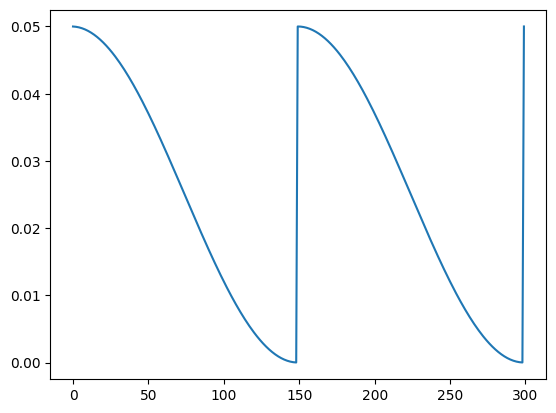

In [148]:
import matplotlib.pyplot as plt

lrs = []

for epoch in range(num_epochs):
    for i in range(num_steps_per_epochs):
        scheduler.step()
    lrs.append(optimizer.param_groups[0]["lr"])

plt.plot(lrs)
plt.show()

From this plot, we can see that the learning rate decayed until epoch 150, at which it was reset to its initial value before decaying again; just as we expected.

**Using the `CosineLRScheduler` scheduler from timm**

Now that we understand how to use PyTorch’s cosine scheduler, let’s explore how this compares with the implementation included in timm, and the additional options that are offered. To begin, let’s replicate the previous plot using timm’s implementation of a cosine learning rate scheduler — `CosineLRScheduler`.

Some of arguments that we will need to do this are similar to those that we have seen before:

- `t_initial` (int): Number of iterations for the first restart, this is equivalent to `T_0` in torch’s implementation
- `lr_min` (float): Minimum learning rate, this is equivalent to eta_min in torch’s implementation (Default: `0.`)
- `cycle_mul` (float): A factor that increases T_{i} after a restart, this is equivalent to T_mult in torch’s implementation (Default: `1`)

However, to observe behaviour consistent with Torch, we will also need to set:

- `cycle_limit` (int): Limit the number of restarts in a cycle (Default: `1`)
- `t_in_epochs` (bool): Whether the number iterations is given in terms of epochs rather than the number of batch updates (Default: `True`)

First, let’s define the same schedule as before.

In [149]:
!pip install timm

In [150]:
import timm
from timm import scheduler

model, optimizer = create_model_and_optimizer()
scheduler = timm.scheduler.CosineLRScheduler(
    optimizer=optimizer,
    t_initial=num_epoch_repeat*num_steps_per_epochs,
    lr_min=1e-6,
    cycle_limit=num_epoch_repeat+1,
    t_in_epochs=False
)

Now, let’s define a new function to simulate using a timm scheduler in a training run and record the updates to the learning rate.

In [151]:
import matplotlib.pyplot as plt

def plot_lrs_for_timm_scheduler(scheduler):
    lrs=[]

    for epoch in range(num_epochs):
        num_updates = epoch * num_steps_per_epochs

        for i in range(num_steps_per_epochs):
            num_updates += 1
            scheduler.step_update(num_updates=num_updates)
        scheduler.step(epoch + 1)
        lrs.append(optimizer.param_groups[0]["lr"])
    plt.plot(lrs)
    plt.xlabel("epochs")
    plt.ylabel("Leanringrate")
    plt.show()

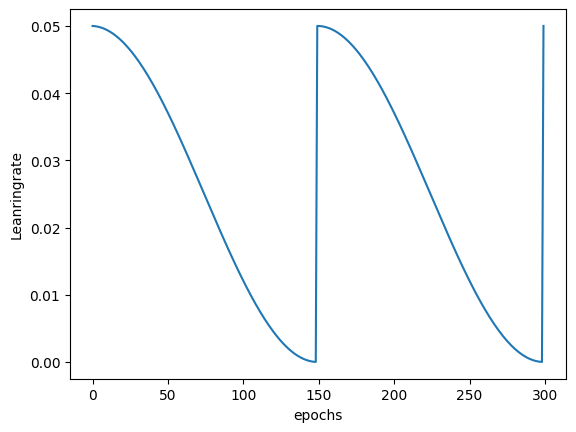

In [152]:
plot_lrs_for_timm_scheduler(scheduler)

As expected, our graph looks identical to the one we saw earlier.

Now that we have replicated the behaviour that we saw in torch, let’s look at some of the additional features that timm offers in more detail.

Until now, we have expressed the number of iterations in terms of optimizer updates; which required us to calculate the number of iterations for the first repeat using `num_epoch_repeat * num_steps_per_epoch`.

 However, by specifying our iterations in terms of epochs — which is the default in timm — we can avoid having to do this calculation. Using the default setting, we can simply pass the index of the epoch at which we would like the first restart to occur, as demonstrated below.

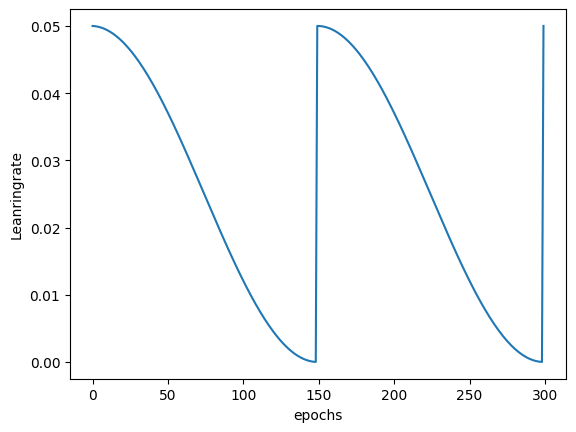

In [153]:
import timm
from timm import scheduler

model, optimizer = create_model_and_optimizer()
scheduler = timm.scheduler.CosineLRScheduler(
    optimizer=optimizer,
    t_initial=num_epoch_repeat,
    lr_min=1e-6,
    cycle_limit=num_epoch_repeat+1,
    t_in_epochs=True
)

plot_lrs_for_timm_scheduler(scheduler)

We can see that our schedule is unchanged, we have just expressed our arguments slightly differently.

**Adding warm up and noise**

Another feature of all timm optimizers, is that they support adding warm up and noise to a learning rate schedule. We can specify the number of warm up epochs, and the initial learning rate to be used during the warm up, with the `warmup_t` and `warmup_lr_init` arguments. Let’s see how our schedule changes if we specify that we would like 20 warm up epochs.



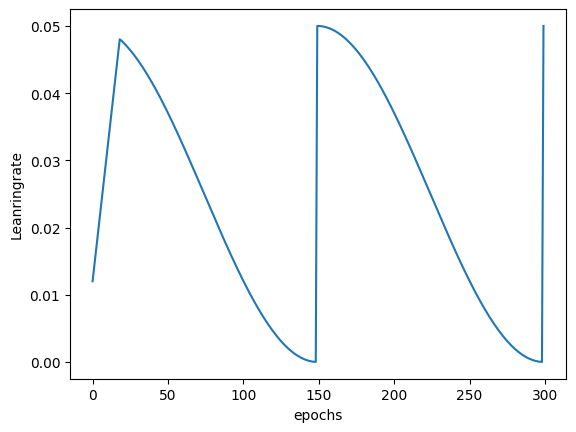

In [154]:
import timm
from timm import scheduler

model, optimizer = create_model_and_optimizer()
scheduler = timm.scheduler.CosineLRScheduler(
    optimizer=optimizer,
    t_initial=num_epoch_repeat,
    lr_min=1e-6,
    cycle_limit=num_epoch_repeat+1,
    warmup_lr_init=0.01,
    warmup_t=20
)

plot_lrs_for_timm_scheduler(scheduler)

Here, we can see that this has resulted in a more gradual increase to our minimum learning rate, rather than starting at that point as we saw before.

We can also add noise to a range of epochs, using the `noise_range_t` and `noise_pct` arguments. Let’s add a small amount of noise to the first 150 epochs:

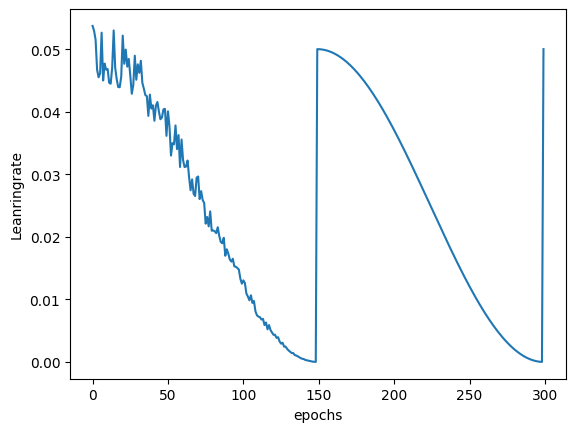

In [155]:
import timm
from timm import scheduler

model, optimizer = create_model_and_optimizer()
scheduler = timm.scheduler.CosineLRScheduler(
    optimizer=optimizer,
    t_initial=num_epoch_repeat,
    lr_min=1e-6,
    cycle_limit=num_epoch_repeat+1,
    noise_pct=0.1,
    noise_range_t=(0, 150)
)

plot_lrs_for_timm_scheduler(scheduler)

We can see that, up until epoch 150, the added noise affects our schedule so that learning rate does not decrease in a smooth curve. We can make this more extreme by increasing noise_pct.

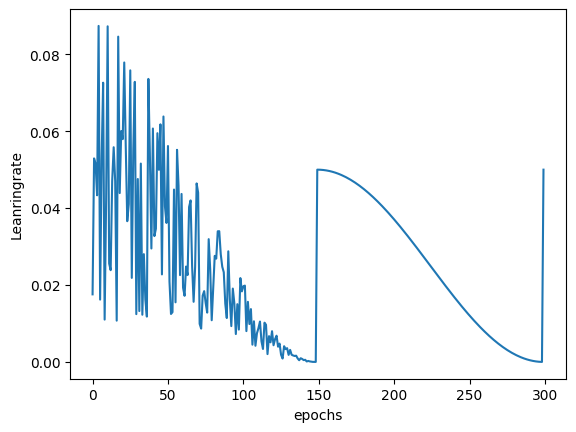

In [156]:
import timm
from timm import scheduler

model, optimizer = create_model_and_optimizer()
scheduler = timm.scheduler.CosineLRScheduler(
    optimizer=optimizer,
    t_initial=num_epoch_repeat,
    lr_min=1e-6,
    cycle_limit=num_epoch_repeat+1,
    noise_pct=0.8,
    noise_range_t=(0, 150)
)

plot_lrs_for_timm_scheduler(scheduler)

**Additional options for `CosineLRScheduler`**

Whilst warm up and noise can be used with any scheduler, there are some additional features which are specific to CosineLRScheduler. Let’s explore how these affect our learning rate cycle.

We can use `cycle_mul`, to increase the time until the next restart, as seen below.



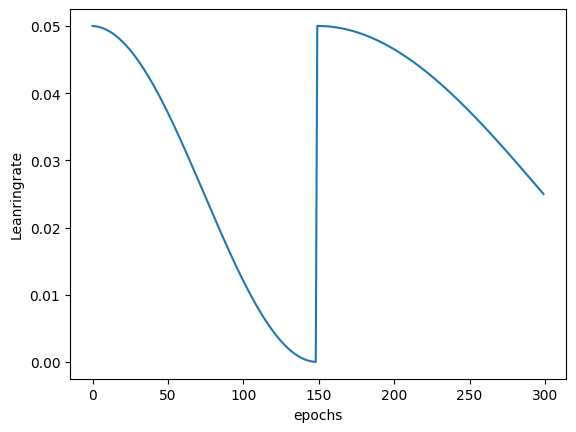

In [157]:
import timm
from timm import scheduler

model, optimizer = create_model_and_optimizer()
scheduler = timm.scheduler.CosineLRScheduler(
    optimizer=optimizer,
    t_initial=num_epoch_repeat*num_steps_per_epochs,
    lr_min=1e-6,
    cycle_limit=num_epoch_repeat+1,
    cycle_mul=2,
    t_in_epochs=False
)

plot_lrs_for_timm_scheduler(scheduler)

Additionally, timm provides the option to limit the number of restarts with `cycle_limit`. By default, this is set to `1`, which results in the following schedule.

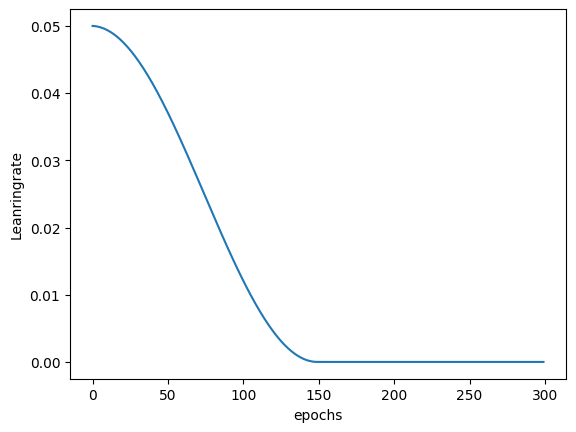

In [158]:
import timm
from timm import scheduler

model, optimizer = create_model_and_optimizer()
scheduler = timm.scheduler.CosineLRScheduler(
    optimizer=optimizer,
    t_initial=num_epoch_repeat,
    lr_min=1e-6,
    cycle_limit=1,
)

plot_lrs_for_timm_scheduler(scheduler)

`CosineLRScheduler` also supports different types of decay. We can use cycle_decay to reduce (or increase) the value of the learning rate that will be set during each successive restart.

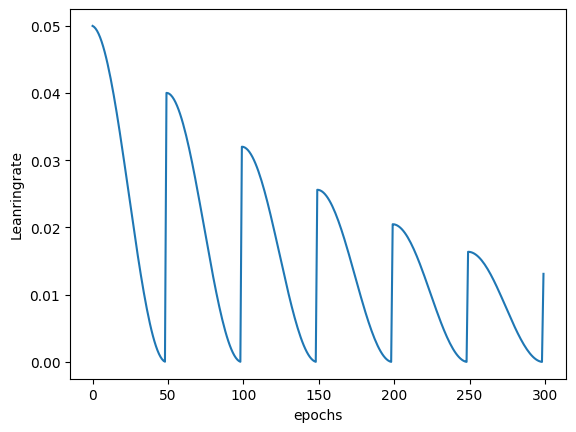

In [159]:
import timm
from timm import scheduler

model, optimizer = create_model_and_optimizer()
scheduler = timm.scheduler.CosineLRScheduler(
    optimizer=optimizer,
    t_initial=50,
    lr_min=1e-6,
    cycle_decay=0.8,
    cycle_limit=num_epoch_repeat+1,
)

plot_lrs_for_timm_scheduler(scheduler)

Note: here we have increased the frequency of the number of restarts to better illustrate the decay.

To control the curve itself, we can use the `k_decay` argument, for which the rate of change of the learning rate is changed by its k-th order derivative, as explained in this paper.https://arxiv.org/abs/2004.05909

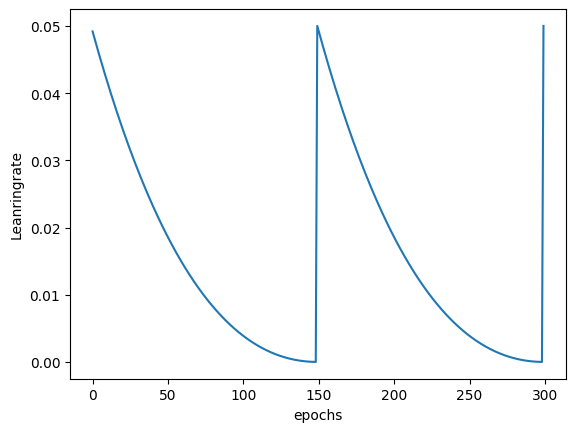

In [160]:
import timm
from timm import scheduler

model, optimizer = create_model_and_optimizer()
scheduler = timm.scheduler.CosineLRScheduler(
    optimizer=optimizer,
    t_initial=num_epoch_repeat,
    lr_min=1e-5,
    k_decay=0.5,
    cycle_limit=num_epoch_repeat+1,
)

plot_lrs_for_timm_scheduler(scheduler)

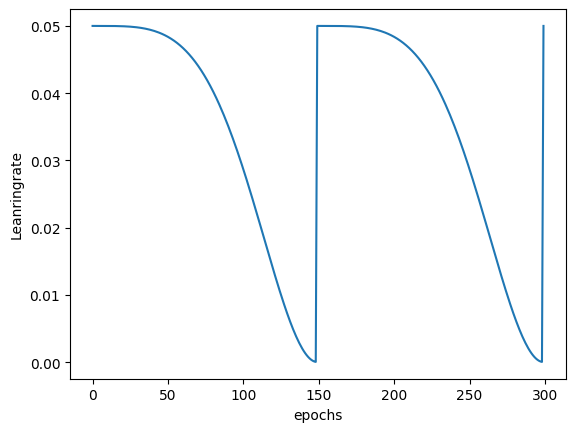

In [161]:
import timm
from timm import scheduler

model, optimizer = create_model_and_optimizer()
scheduler = timm.scheduler.CosineLRScheduler(
    optimizer=optimizer,
    t_initial=num_epoch_repeat,
    lr_min=1e-5,
    k_decay=2,
    cycle_limit=num_epoch_repeat+1,
)

plot_lrs_for_timm_scheduler(scheduler)

This option provides even more control over the annealing performed by this scheduler!

**Default settings in timm’s training script**

If we set this scheduler using the default settings from timm’s training script, we observe the following schedule.

Note: in the training script, training continues for an additional 10 epochs without further modifications to the learning rate as a ‘cool down’.

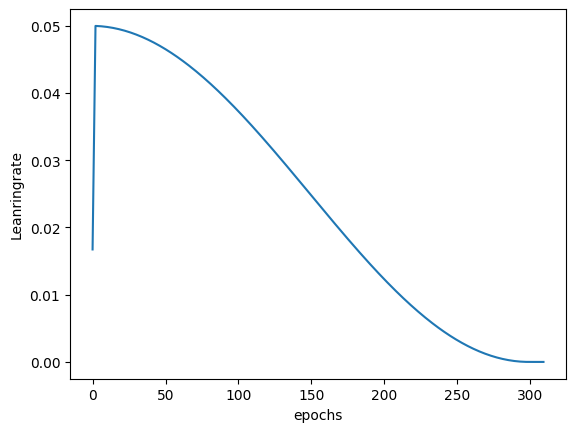

In [162]:
import timm
from timm import scheduler

model, optimizer = create_model_and_optimizer()

training_epochs = 300
cooldown_epochs = 10
num_epochs = training_epochs + cooldown_epochs
num_steps_per_epoch = 10

scheduler = timm.scheduler.CosineLRScheduler(
    optimizer=optimizer,
    t_initial=training_epochs,
    lr_min=1e-6,
    t_in_epochs=True,
    warmup_t=3,
    warmup_lr_init=1e-4,
    cycle_limit=1,
)

plot_lrs_for_timm_scheduler(scheduler)

As we can see, there are no restarts at all with the default settings!

####**Other learning rate schedules**

Whilst my favourite of the schedulers included with timm is `CosineLRScheduler`, it may be helpful to visualise the schedules of some of the other schedulers, that have no counterpart in PyTorch. Both of these schedulers are similar to the cosine scheduler in the sense that the learning rate is reset after a specified number epochs — assuming a cycle limit is not set — but the annealing is done slightly differently.

For the `TanhLRScheduler`, annealing is performed using the hyperbolic-tangent function, as demonstrated below.

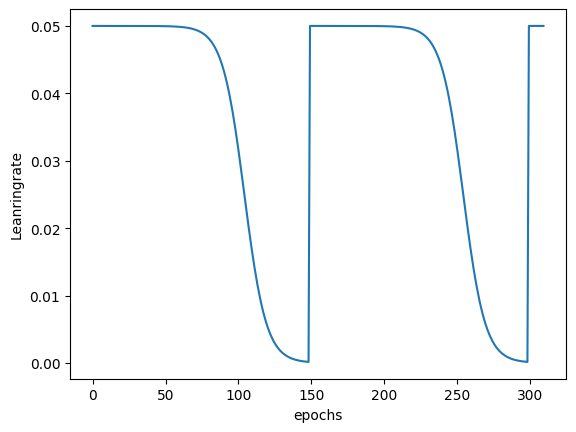

In [163]:
import timm
from timm import scheduler

model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.TanhLRScheduler(
    optimizer=optimizer,
    t_initial=num_epoch_repeat,
    lr_min=1e-5,
    cycle_limit=num_epoch_repeat+1,
)

plot_lrs_for_timm_scheduler(scheduler)

timm also provides `PolyLRScheduler`, which uses a polynomial decay:

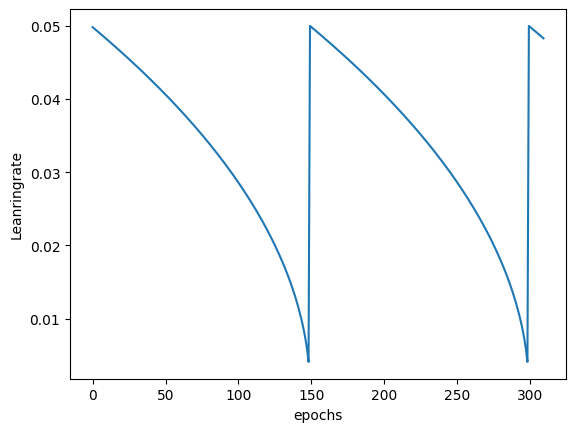

In [164]:
import timm
from timm import scheduler

model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.PolyLRScheduler(
    optimizer=optimizer,
    t_initial=num_epoch_repeat,
    lr_min=1e-5,
    cycle_limit=num_epoch_repeat+1,
)

plot_lrs_for_timm_scheduler(scheduler)

Similarly to `CosineLRScheduler`, the `PolyLRScheduler` scheduler also supports the `k_decay` argument, as demonstrated below:

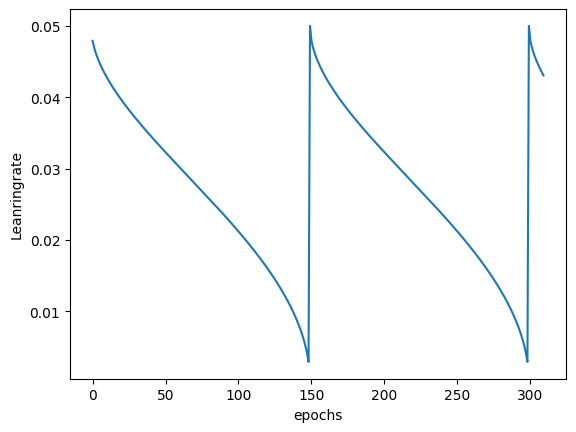

In [165]:
import timm
from timm import scheduler

model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.PolyLRScheduler(
    optimizer=optimizer,
    t_initial=num_epoch_repeat,
    lr_min=1e-5,
    cycle_limit=num_epoch_repeat+1,
    k_decay=0.5
)

plot_lrs_for_timm_scheduler(scheduler)

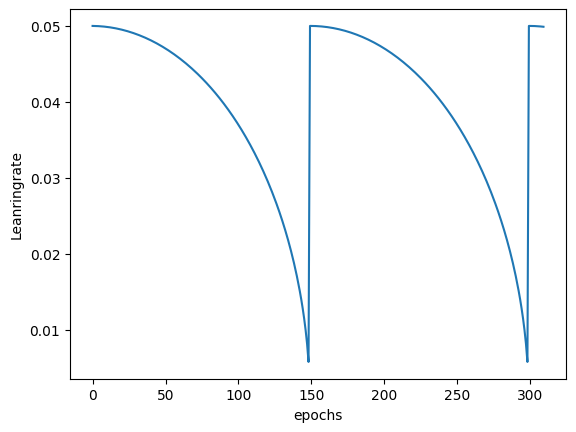

In [166]:
import timm
from timm import scheduler

model, optimizer = create_model_and_optimizer()

scheduler = timm.scheduler.PolyLRScheduler(
    optimizer=optimizer,
    t_initial=num_epoch_repeat,
    lr_min=1e-5,
    cycle_limit=num_epoch_repeat+1,
    k_decay=2
)

plot_lrs_for_timm_scheduler(scheduler)

###**Exponential Moving Average Model**
When training a model, it can be beneficial to set the values for the model weights by taking a moving average of the parameters that were observed across the entire training run, as opposed to using the parameters obtained after the last incremental update. In practice, this is often done by maintaining an EMA model, which is a copy of the model that we are training. However, rather than updating all of the parameters of this model after every update step, we set these parameters using a linear combination of the existing parameter values and the updated values. This is done using the following formula:

```updated_EMA_model_weights = decay * EMA_model_weights + (1. — decay) * updated_model_weights ```

where the ```_decay_``` is a parameter that we set. For example, if we set decay=0.99, we have:

```updated_EMA_model_weights = 0.99 * EMA_model_weights + 0.01 * updated_model_weights ```

which we can see is keeping 99% of the existing state and only 1% of the new state!

To understand why this may be beneficial, let’s consider the case that our model, in an early stage of training, performs exceptionally poorly on a batch of data. This may result in a large update update to our parameters, overcompensating for the high loss obtained, which will be detrimental for the upcoming batches. By only incorporating only a small percentage of the latest parameters, large updates will be ‘smoothed’, and have less of an overall impact on the model’s weights.

Sometimes, these averaged parameters can sometimes produce significantly better results during evaluation, and this technique has been employed in several training schemes for popular models such as training ```MNASNet, MobileNet-V3 and EfficientNet```; using the implementation included in TensorFlow. Using the ```ModelEmaV2``` module implemented in timm, we can replicate this behaviour, and apply the same practice to our own training scripts.

The implementation of ```ModelEmaV2``` expects the following arguments:

- ```model```: the subclass of nn.Module that we are training. This is the model that will be updated in our training loop as normal
- ```decay```: (float) the amount of decay to use, which determines how much of the previous state will be maintained. The TensorFlow documentation suggests that reasonable values for decay are close to 1.0, typically in the multiple-nines range: 0.999, 0.9999, etc. (Default: `0.9999`)
- ```device```: the device that should be used to evaluate the EMA model. If this is not set, the EMA model will be created on the same device that is being used for the model.

Let’s explore how we can incorporate this in a training loop.

```
from timm.models import create_model
from timm.utils import ModelEmaV2

device = "cuda" if torch.cuda.is_available() else "cpu"
model = create_model(model_name="resnet50.a1_in1k", pretrained=True)
optimizer = timm.optim.AdamW(params = model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
ema_model = ModelEmaV2(model=model, decay=0.9999, device=device)

#create dataset and dataloader ...

#training
for epoch in range(num_epochs):
    for X, Y in train_dataloader:
        Y_pred = model(X)
        loss = loss_fn(Y_pred, Y)
        loss.backward()
        optimizer.step() #usual model update
        optimizer.zero_grad()
        ema_model.update(model) #ema model update
    for batch in validation_dataloader:
        inputs, target = batch
        Y_val_preds = model(inputs)
        val_loss = loss_fn(Y_pred, Y)

        ema_model_outputs = ema_model.module(inputs)
        ema_model_validation_loss = loss_fn(ema_model_outputs, targets)
```

As we can see, to update the parameters of the EMA model, we need to call ```.update``` after each parameter update. As the EMA model has different parameters to the one being trained, we must evaluate this separately.

It is important to note that this class is sensitive to where it is initialised. During distributed training, it should be applied before before the conversion to ```SyncBatchNorm``` takes place and before the ```DistributedDataParallel``` wrapper is used!

Additionally, when saving the EMA model, the keys inside the ```state_dict``` will be the same as those for the model being trained, so a ```different checkpoint``` should be used!

###**Putting it all together!**
Whilst the pseudocode snippets throughout this article illustrate how each component can be used in a training loop individually, let’s explore an example where we use many different components at once!

Here, we shall look at training a model on Imagenette. Note that, as Imagenette is a subset of Imagenet, if we use a pretrained model we are cheating slightly, as only the new classification head will be initialised with random weights; therefore, in this example, we shall train from scratch.

**Note**: The purpose of this example is to demonstrate how multiple components from timm can be used together. As such, the features selected — and the hyperparameters used — have been selected somewhat arbitrarily; so the performance could probably be improved with some careful tuning!

To remove the boilerplate that we usually see in PyTorch training loops, such as iterating through the DataLoaders and moving data between devices, we shall use `PyTorch-accelerated` to handle our training; this enables us to focus only on the differences that are required when using timm components.

If you are unfamiliar with PyTorch-accelerated and would like to learn more about it before diving into this article, please check out the introductory blog post https://medium.com/@chris.p.hughes10/introducing-pytorch-accelerated-6ba99530608c?sk=868c2d2ec5229fdea42877c0bf82b968 or the docs https://pytorch-accelerated.readthedocs.io/en/latest/index.html#; alternatively, it’s very simple and a lack of knowledge in this area should not impair your understanding of the content explored here!

In PyTorch-accelerated, the training loop is handled by the `Trainer` class; where we can override specific methods to change the behaviour at certain steps. In pseudocode, the execution of a training run inside of the PyTorch-accelerated Trainer can be depicted as:

```
train_dl = create_train_dataloader()
eval_dl = create_eval_dataloader()
scheduler = create_scheduler()

training_run_start()
on_training_run_start()

for epoch in num_epochs:
    train_epoch_start()
    on_train_epoch_start()
    for batch in train_dl:
        on_train_step_start()
        batch_output = calculate_train_batch_loss(batch)
        on_train_step_end(batch, batch_output)
        backward_step(batch_output["loss"])
        optimizer_step()
        scheduler_step()
        optimizer_zero_grad()
    train_epoch_end()
    on_train_epoch_end()

    eval_epoch_start()
    on_eval_epoch_start()
    for batch in eval_dl:
        on_eval_step_start()
        batch_output = calculate_eval_batch_loss(batch)
        on_eval_step_end(batch, batch_output)
    eval_epoch_end()
    on_eval_epoch_end()

    training_run_epoch_end()
    on_training_run_epoch_end()

training_run_end()
on_training_run_end()
```

More details about how the Trainer works can be found in the documentation. https://pytorch-accelerated.readthedocs.io/en/latest/trainer.html#

We can subclass the default trainer, and use this in a training script, as demonstrated below:



Using this training script on Imagenette using 2 GPUs, following the instructions here https://pytorch-accelerated.readthedocs.io/en/latest/quickstart.html, I obtained the following metrics:

- accuracy: 0.89
- ema_model_accuracy: 0.85

after 34 epochs; which isn’t bad considering that the hyperparameters haven’t been tuned!

###**Conclusion**
Hopefully that has provided a somewhat comprehensive overview of some of the features included in timm, and how these can be applied in custom training scripts.

Finally, I’d like to take a moment to acknowledge the sheer amount of effort that has been put into creating this awesome library by Ross Wightman, the creator of timm. Ross’s dedication to providing implementations of state-of-the-art computer vision models that are easily accessible to the whole data science community is second to none. If you haven’t already, go and add stars!

All of the code required to replicate this post is available as a GitHub gist here. https://gist.github.com/Chris-hughes10/a9e5ec2cd7e7736c651bf89b5484b4a9

To launch training using the accelerate CLI on your machine(s), run:

```accelerate config --config_file accelerate_config.yaml```

and answer the questions asked. This will generate a config file that will be used to properly set the default options when doing:

```accelerate launch --config_file accelerate_config.yaml train.py [--training-args]```

**Note:**
Using the accelerate CLI https://huggingface.co/docs/accelerate/quicktour.html#launching-your-distributed-script is completely optional, training can also be launched in the usual way using:

```python train.py / python -m torch.distributed ...```

depending on your infrastructure configuration, for users who would like to maintain a more fine-grained control over the launch command.

**Running in a Notebook**
Accelerate also provides a ```notebook_launcher()``` function, that can be used to launch distributed training from a notebook; which is especially useful for Colab or Kaggle notebooks.

To train a model using ```pytorch_accelerated from a notebook```, just define the ```Trainer```() in a ```training_function```, and use this as an argument into ```notebook_launcher```. To run the example below in a notebook, we would use:

```notebook_launcher(main, num_processes=num_gpus)```

More information about training in a notebook can be found here https://huggingface.co/docs/accelerate/launcher.html

**Debugging with an IDE**
Whilst `pytorch_accelerated` is primarily designed to be launched using the accelerate CLI, sometimes it’s useful to debug a training script in your favourite editor to see exactly what’s going on!

In these cases, we can simply use the `notebook_launcher()` function as described above. To debug the example above, after setting some breakpoints, replace the lines:

```
if __name__ == "__main__":
    main()
```
with:

```
notebook_launcher(main, num_processes=num_gpus)
```

https://www.kaggle.com/code/abdulrehman0555/multi-gpu-and-accelerate
https://pytorch-accelerated.readthedocs.io/en/latest/quickstart.html
https://huggingface.co/docs/accelerate/v0.11.0/en/launcher
https://wandb.ai/gladiator/HF%20Accelerate%20+%20W&B/reports/Hugging-Face-Accelerate-Super-Charged-With-Weights-Biases--VmlldzoyNzk3MDUx

In [15]:
import argparse
from pathlib import Path

from timm.models import create_model
import timm.data
import timm.optim
import timm.loss
import timm.utils
import torch
from timm.scheduler import CosineLRScheduler
from accelerate import notebook_launcher

try:
    import torchmetrics, pytorch_accelerated
except:
    !pip install torchmetrics

try:
    import pytorch_accelerated
except:
    !pip install pytorch_accelerated

import torchmetrics
import pytorch_accelerated

from pytorch_accelerated.callbacks import SaveBestModelCallback
from pytorch_accelerated.trainer import Trainer, DEFAULT_CALLBACKS


class TimmMixupTrainer(Trainer):
    #overiding some methods of original Trainer by subclassing it
    def __init__(self, eval_loss_fn, mixup_args, num_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.eval_loss_fn = eval_loss_fn
        self.mixup_fn = timm.data.Mixup(**mixup_args)
        self.num_classes = num_classes
        self.num_updates = None
        self.ema_model = None
        self.accuracy = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self.ema_accuracy = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")

    def create_scheduler(self):
        return timm.scheduler.CosineLRScheduler(
            optimizer=self.optimizer,
            t_initial=self.run_config.num_epochs,
            cycle_decay=0.5,
            lr_min=1e-6,
            t_in_epochs=True,
            warmup_t=3,
            warmup_lr_init=1e-4,
            cycle_limit=1
        )

    def training_run_start(self):
        # Model EMA requires the model without a DDP wrapper and before sync batchnorm conversion
        self.ema_model = timm.utils.ModelEmaV2(
            self._accelerator.unwrap_model(self.model), decay=0.9
        )
        if self.run_config.is_distributed:
            self.model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(self.model)


    def train_epoch_start(self):
        super().train_epoch_start()
        self.num_updates = self.run_history.current_epoch * len(self._train_dataloader)

    def calculate_train_batch_loss(self, batch) -> dict:
        xb, yb = batch
        mixup_xb, mixup_yb = self.mixup_fn(xb, yb)
        return super().calculate_train_batch_loss((mixup_xb, mixup_yb))

    def train_epoch_end(self):
        self.ema_model.update(self.model)
        self.ema_model.eval()
        if hasattr(self.optimizer, "sync_lookahead"):
            self.optimizer.sync_lookahead()

    def scheduler_step(self):
        self.num_updates += 1
        if self.scheduler is not None:
            self.scheduler.step_update(num_updates=self.num_updates)

    def calculate_eval_batch_loss(self, batch) -> dict:
        with torch.inference_mode():
            xb, yb = batch
            outputs = self.model(xb)
            val_loss = self.eval_loss_fn(outputs, yb)
            self.acccuracy.update(outputs.argmax(-1), yb)

            ema_model_preds = self.ema_model.module(xb).argmax(-1)
            self.ema_accuracy.update(ema_model_preds, yb)
        return {"loss": val_loss, "model_outputs": outputs, "batch_size":xb.size(0)}

    def eval_epoch_end(self):
        super().eval_epoch_end()
        if self.scheduler is not None:
            self.scheduler.step(self.run_history.current_epoch + 1)
        self.run_history.update_metric("accuracy", self.accuracy.compute().cpu())
        self.run_history.update_metric("ema_model_accuracy",
                                       self.ema_accuracy.compute().cpu())
        self.accuracy.reset()
        self.ema_accuracy.reset()

def create_datasets(image_size, data_mean, data_std, train_path, val_path):
    train_transforms = timm.data.create_transform(input_size=image_size,
                                                  is_training=True,
                                                  mean=data_mean,
                                                  std=data_std,
                                                  auto_augment="rand-m7-mstd0.5-inc1")
    val_transforms = timm.data.create_transform(input_size=image_size,
                                                mean=data_mean,
                                                std=data_std)
    train_dataset = timm.data.dataset.ImageDataset(root=train_path,
                                                   transform=train_transforms)
    val_dataset = timm.data.dataset.ImageDataset(root=val_path,
                                                 transform=val_transforms)
    return train_dataset, val_dataset

# def main(data_path):
def main():
    data_path = "./imagenette2-320"
    #set training args, hardoded for clarity
    image_size = (224, 224)
    lr = 5e-3
    smoothing = 0.1
    mixup = 0.2
    cutmix = 1.0
    batch_size = 32
    bce_target_thresh = 0.2
    num_epochs = 40

    data_path = Path(data_path)
    train_dir = data_path / "train"
    val_dir = data_path / "val"

    num_classes = len(list(train_dir.iterdir()))

    mixup_args = dict(
        mixup_alpha = mixup,
        cutmix_alpha = cutmix,
        label_smoothing = smoothing,
        num_classes = num_classes,
    )

    #create model using timm
    model = create_model(model_name="resnet50d.a1_in1k", pretrained=False,
                 num_classes=num_classes, drop_path_rate=0.05)

    # Load the data config associated with the pretrained model to use in data augmentation pipeline
    data_config = timm.data.resolve_data_config(args={}, model=model, verbose=True)
    data_mean = data_config["mean"]
    data_std = data_config["std"]

    # Create training and validation datasets
    train_dataset, val_dataset = create_datasets(data_mean=data_mean,
                                                 data_std=data_std,
                                                 image_size=image_size,
                                                 train_path=train_dir,
                                                 val_path=val_dir)

    # Create optimizer
    optimizer = timm.optim.create_optimizer_v2(model_or_params=model,
                                   lr=lr,
                                   opt="lookahead_AdamW",
                                   weight_decay=0.01)

    # Loss - As we are using Mixup, we can use BCE during training and CE for evaluation
    train_loss_fn = timm.loss.BinaryCrossEntropy(smoothing=smoothing,
                                                 target_threshold=bce_target_thresh)
    val_loss_fn = torch.nn.CrossEntropyLoss()

    # Create trainer and start training - trainer from pytorch_accelerate reduces the steps like iterating through data loader with less code, see the links in the above text
    trainer = TimmMixupTrainer(model=model,
                               optimizer=optimizer,
                               loss_func=train_loss_fn,
                               eval_loss_fn=val_loss_fn,
                               mixup_args=mixup_args,
                               num_classes=num_classes,
                               callbacks=[
                                   *DEFAULT_CALLBACKS,
                                   SaveBestModelCallback(watch_metric="accuracy", greater_is_better=True)
                               ])
    trainer.train(
        train_dataset=train_dataset,
        num_epochs=num_epochs,
        eval_dataset=val_dataset,
        per_device_batch_size=batch_size,
        create_scheduler_fn=trainer.create_scheduler,
    )
    trainer.evaluate(
        dataset=val_dataset,
    )

if __name__ == "__main__":
    # parser = argparse.ArgumentParser(description="Simple example of training script using timm")
    # parser.add_argument("--data_dir", required=True, help="The data folder on disk")
    # args = parser.parse_args()
    # main(args.data_dir)
    main()

#So let's do so! We'll make a tuple of our mixed precision mode (fp16), our seed (42), and the batch size to train on (64):

args = ("fp16", 42, 64)
accelerate.notebook_launcher(function=main, args=args, num_processes=2)


Starting training run

Starting epoch 1



100%|█████████▉| 295/296 [2:09:44<00:25, 25.92s/it]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 194>:199                                                                          │
│ in main:183                                                                                      │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/pytorch_accelerated/trainer.py:469 in train              │
│                                                                                                  │
│    466 │   │   if self.create_scheduler_fn is not None:                                          │
│    467 │   │   │   self.scheduler = self.create_scheduler()                                      │
│    468 │   │                                                                                     │
│ ❱  469 │   │   self._run_training()                                                              │
│    470 │                                                                                         │
│    471 │   def evaluate(                                                                         │
│    472 │   │   self,                                                                             │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/pytorch_accelerated/trainer.py:728 in _run_training      │
│                                                                                                  │
│    725 │   │   )                                                                                 │
│    726 │   │   for epoch in range(self.run_config.num_epochs):                                   │
│    727 │   │   │   try:                                                                          │
│ ❱  728 │   │   │   │   self._run_train_epoch(self._train_dataloader)                             │
│    729 │   │   │   │   if self.eval_dataset is not None:                                         │
│    730 │   │   │   │   │   self._run_eval_epoch(self._eval_dataloader)                           │
│    731 │   │   │   │   self.training_run_epoch_end()                                             │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/pytorch_accelerated/trainer.py:801 in _run_train_epoch   │
│                                                                                                  │
│    798 │   │   │   │   with self._accelerator.no_sync(self.model):                               │
│    799 │   │   │   │   │   self._perform_forward_and_backward_passes(batch)                      │
│    800 │   │   │   else:                                                                         │
│ ❱  801 │   │   │   │   self._perform_forward_and_backward_passes(batch)                          │
│    802 │   │   │                                                                                 │
│    803 │   │   │   if self.run_config.gradient_clip_value is not None:                           │
│    804 │   │   │   │   self._clip_gradients()                                                    │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/pytorch_accelerated/trainer.py:828 in                    │
│ _perform_forward_and_backward_passes                                                             │
│                                                                                                  │
│    825 │   │                                                                                     │
│    826 │   │   :param batch: the current batch of data                                           │
│    827 │   │   """                                         

In [8]:
!pip show accelerate

Name: accelerate
Version: 0.20.3
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, packaging, psutil, pyyaml, torch
Required-by: pytorch-accelerated


In [10]:
from accelerate import notebook_launcher
notebook_launcher?

In [4]:
model = create_model(model_name="resnet50d.a1_in1k", pretrained=False,
                 num_classes=10, drop_path_rate=0.05)

# Load the data config associated with the model to use in data augmentation pipeline
data_config = timm.data.resolve_data_config(args={}, model=model, verbose=True)
data_config

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.95,
 'crop_mode': 'center'}